# Earthquake data science project

The National Centers for Environmental Information (NCEI) has historical earthquake data (from 2000BC to present) available for use. It can be extracted using their API.

The data itself contains a large number of features from the year the earthquake occured to the amount of damage done by the earthquake and the number of people that went missing.

The aim of the project is to predict the number of deaths based on the earthquakes features. This is discussed further as the project progresses.

In [1]:
import urllib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from os.path import exists
import json
from pathlib import Path
import numpy as np
import plotly.express as px

# Feature/value definitions

NCEI API contains definitions of certain terms contained in the data. These are read using the descriptors module and shown here.

In [2]:
from descriptors import fetch_descriptor

In [3]:
# ID : Cost of damage
damage = fetch_descriptor('effect/damage')
damage

,id,description
0,0,None
1,1,Limited (<$1 million)
2,2,Moderate (~$1 to $5 million)
3,3,Severe (~>$5 to $24 million)
4,4,Extreme (~$25 million or more)


In [4]:
# ID : Number of houses affected
houses = fetch_descriptor('effect/houses')
houses

,id,description
0,0,None
1,1,Few (~1 to 50 houses)
2,2,Some (~51 to 100 houses)
3,3,Many (~101 to 1000 houses)
4,4,Very Many (~1001 or more houses)


In [5]:
# ID : Number of people affected
people = fetch_descriptor('effect/people')
people

,id,description
0,0,None
1,1,Few (~1 to 50 people)
2,2,Some (~51 to 100 people)
3,3,Many (~101 to 1000 people)
4,4,Very Many (~1001 or more people)


In [6]:
# ID : area of the world
regions = fetch_descriptor('earthquake/regions')
# Edit df for consistency with data columns (read later)
regions.rename({"id": "regionCode"}, axis=1, inplace=True)
regions['regionCode'] = regions['regionCode'].astype(int)
regions.set_index('regionCode', inplace=True)
regions

,description
regionCode,
10,"Central, Western and S. Africa"
15,Northern Africa
20,Antarctica
30,East Asia
40,Central Asia and Caucasus
50,Kamchatka and Kuril Islands
60,S. and SE. Asia and Indian Ocean
70,Atlantic Ocean
80,Bering Sea


# Read data

Data obtained from the API available via the National Centers for Environmental Information (NCEI; formally National Geophysical Data Center (NGDC)).

https://www.ngdc.noaa.gov

Citation: National Geophysical Data Center / World Data Service (NGDC/WDS): NCEI/WDS Global Significant Earthquake Database. NOAA National Centers for Environmental Information. doi:10.7289/V5TD9V7K [23/05/22]

API documentation:
- Click headings in table: https://www.ngdc.noaa.gov/hazel/view/hazards/earthquake/event-data
- List of available descriptors: https://www.ngdc.noaa.gov/hazel/view/swagger#/

The API documentation is not particularly clear so the start of the EDA section below gives descriptions of some of the unclear data columns as I have understood them.

In [7]:
# API url
url = 'https://www.ngdc.noaa.gov/hazel/hazard-service/api/v1/earthquakes'

In [8]:
Path("data").mkdir(parents=True, exist_ok=True) # Make directory to hold json files if not already created

In [9]:
# Retrieve data from url and write to json file
urllib.request.urlretrieve(url, 'data/earthquake-data.json')

('data/earthquake-data.json', <http.client.HTTPMessage at 0x22f27902f10>)

In [10]:
# Load data using Python JSON module
with open('data/earthquake-data.json','r') as f:
    data = json.loads(f.read())

In [11]:
eq = pd.json_normalize(data, record_path=['items'])
eq.set_index('id', inplace=True)

In [12]:
eq.head()

,year,locationName,latitude,longitude,intensity,damageAmountOrder,publish,damageAmountOrderTotal,country,regionCode,...,eqMagMb,damageMillionsDollars,damageMillionsDollarsTotal,housesDamaged,missingAmountOrderTotal,eqMagMl,missing,missingAmountOrder,missingTotal,eqMagMfa
id,,,,,,,,,,,,,,,,,,,,,
40,17,"TURKEY: IZMIR, EFES, AYDIN, MANISA, ALASEHIR,...",37.850,27.300,10.0,3.0,True,3.0,TURKEY,140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,52,"GREECE: PHILIPPI,DRAMA,KAVALA",41.000,24.300,NaN,3.0,True,NaN,GREECE,130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,79,ITALY: NAPLES (NAPOLI),40.821,14.426,10.0,NaN,True,NaN,ITALY,130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,93,TURKEY: HELLESPONT,40.600,26.700,NaN,3.0,True,NaN,TURKEY,140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,138,CHINA: GANSU PROVINCE,35.800,103.500,9.0,3.0,True,3.0,CHINA,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory data analysis

## Structure

In [13]:
eq.shape

(6327, 48)

In [14]:
eq.columns

Index(['year', 'locationName', 'latitude', 'longitude', 'intensity',
       'damageAmountOrder', 'publish', 'damageAmountOrderTotal', 'country',
       'regionCode', 'second', 'month', 'day', 'tsunamiEventId',
       'volcanoEventId', 'deathsTotal', 'deathsAmountOrderTotal',
       'deathsAmountOrder', 'eqMagnitude', 'housesDestroyedAmountOrder',
       'eqMagMs', 'housesDestroyedAmountOrderTotal', 'deaths', 'eqDepth',
       'eqMagUnk', 'hour', 'minute', 'housesDestroyedTotal', 'housesDestroyed',
       'injuriesAmountOrder', 'injuriesAmountOrderTotal',
       'housesDamagedAmountOrder', 'housesDamagedAmountOrderTotal', 'eqMagMw',
       'housesDamagedTotal', 'injuries', 'injuriesTotal', 'area', 'eqMagMb',
       'damageMillionsDollars', 'damageMillionsDollarsTotal', 'housesDamaged',
       'missingAmountOrderTotal', 'eqMagMl', 'missing', 'missingAmountOrder',
       'missingTotal', 'eqMagMfa'],
      dtype='object')

In [15]:
eq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6327 entries, 40 to 10640
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   year                             6327 non-null   int64  
 1   locationName                     6326 non-null   object 
 2   latitude                         6275 non-null   float64
 3   longitude                        6275 non-null   float64
 4   intensity                        3007 non-null   float64
 5   damageAmountOrder                4575 non-null   float64
 6   publish                          6327 non-null   bool   
 7   damageAmountOrderTotal           3601 non-null   float64
 8   country                          6326 non-null   object 
 9   regionCode                       6327 non-null   int64  
 10  second                           4414 non-null   float64
 11  month                            5916 non-null   float64
 12  day               

- Lots of missing data that will be dealt with later.
- Some datatypes can be changed (e.g. year, month etc).

API documentation states that e.g. deathsTotal is the total number of deaths from the earthquake as well as its secondary effects, such as tsunamis and volcanoes. Same for missing, damage etc.

When a column contains 'AmountOrder', e.g. deathsAmountOrder, the value represents a classification of the number of deaths. In literature, the exact number of deaths is not always recorded so has to be estimated based on other factors.  For cases where the exact number of deaths is given, a classification is still given for completeness.

In [16]:
eq.describe(exclude='number')

,locationName,publish,country,area
count,6326,6327,6326,326
unique,3932,1,156,32
top,CHINA: YUNNAN PROVINCE,True,CHINA,CA
freq,68,6327,615,103


- Country with most earthquakes is China, specifically the Yunnan province.
- 'publish' is true in every case (unclear from API documentation what this is - possibly whether earthquake details are published somewhere?).
- Area with most earthquakes is CA. These appear to be North American state codes (see here for list: https://www.fs.fed.us/database/feis/format.html) so CA is California.
- Seems to be overlap between 'area' and 'locationName'.  'area' could be expanded to non-NA states by extracting the location from 'locationName'. Could use 'country' for this.  Or vice verse, could add 'area' to 'locationName'.

In [17]:
eq.iloc[:, 0:10].describe() # Show 9 columns only so whole df is shown and can be discussed bit by bit

,year,latitude,longitude,intensity,damageAmountOrder,damageAmountOrderTotal,regionCode
count,6327.000000,6275.000000,6275.000000,3007.000000,4575.000000,3601.000000,6327.000000
mean,1808.127549,22.336747,38.019245,8.243099,2.272787,2.221883,106.912439
std,374.498871,22.895605,86.774092,1.803679,0.957967,1.022214,53.662508
min,-2150.000000,-62.877000,-179.984000,2.000000,1.000000,1.000000,10.000000
25%,1822.500000,9.300000,-8.600000,7.000000,2.000000,1.000000,50.000000
50%,1930.000000,32.000000,43.400000,8.000000,2.000000,2.000000,130.000000
75%,1990.000000,38.700000,115.300000,10.000000,3.000000,3.000000,150.000000
max,2022.000000,73.122000,180.000000,12.000000,4.000000,4.000000,170.000000


- Dataset consists of earthquakes recorded from 2150BC to 2022AD. Most are more recent than ~1800.
- 'intensity' is actually the MMI intensity (modified Mercalli intensity) - values range from 1 to 12 where 1 is "not felt other than in especially favorable circumstances" and 12 is "Damage total - waves seen on ground surface and line of sight distorted".
- 'damageAmountOrder' is a five-level scale used to classify damage (based on current U.S. dollars). See 'damage' dataframe in Definitions section for what each code means. This was required as exact amount of damage not always clear from literature. 'damageAmountOrderTotal' is the same except also includes the earthquakes secondary effects.
- 'regionCode' is an integer code corresponding to the region of the World. See 'regions' dataframe in Definitions section for what each code means.

In [18]:
eq.iloc[:, 10:19].describe()

,second,month,day,tsunamiEventId,volcanoEventId,deathsTotal,deathsAmountOrderTotal,deathsAmountOrder,eqMagnitude
count,4414.000000,5916.000000,5760.000000,1948.000000,77.000000,1900.000000,2269.000000,2600.000000,4548.000000
mean,19.770072,6.498141,15.757986,2285.774641,3702.662338,3898.302632,1.959454,2.002308,6.450220
std,19.658613,3.447639,8.733207,1692.773064,2414.828427,26871.142639,1.165772,1.154143,1.039659
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.600000
25%,0.000000,4.000000,8.000000,1022.250000,1346.000000,3.000000,1.000000,1.000000,5.700000
50%,14.700000,7.000000,16.000000,1883.500000,3833.000000,18.000000,1.000000,1.000000,6.500000
75%,36.775000,9.000000,23.000000,3166.500000,5324.000000,256.000000,3.000000,3.000000,7.300000
max,59.900000,12.000000,31.000000,5854.000000,7542.000000,830000.000000,4.000000,4.000000,9.500000


- 'second', 'month' and 'day' can be combined into datetime object later (with other time related columns).
- 'tsunamiEventId' and 'volcanoEventId' are the id number of the tsunami/volcano eruption caused by each earthquake, if applicable.
- 'deathsTotal' likely contains some outliers as mean long way from median.
- eqMagnitude is the standard earthquake magnitude measurement (energy released at the source of the earthquake).  For pre-instrumental events, the magnitudes are derived from intensities.

In [19]:
eq.iloc[:, 19:30].describe()

,housesDestroyedAmountOrder,eqMagMs,housesDestroyedAmountOrderTotal,deaths,eqDepth,eqMagUnk,hour,minute,housesDestroyedTotal,housesDestroyed,injuriesAmountOrder
count,1826.000000,2985.000000,1908.000000,2116.000000,3352.000000,794.000000,4275.000000,4070.000000,8.780000e+02,8.460000e+02,1551.000000
mean,2.677985,6.566834,2.685535,3710.768904,40.429594,6.652141,11.308070,28.745946,1.757487e+04,1.703936e+04,1.957447
std,1.061055,0.988329,1.055691,25109.056383,69.662038,1.005622,7.018981,17.166163,1.887096e+05,1.906010e+05,1.079185
min,0.000000,2.100000,1.000000,1.000000,0.000000,3.200000,0.000000,0.000000,1.000000e+00,1.000000e+00,1.000000
25%,2.000000,5.800000,2.000000,3.000000,10.000000,6.000000,5.000000,14.000000,6.525000e+01,6.700000e+01,1.000000
50%,3.000000,6.600000,3.000000,20.000000,25.000000,6.800000,11.000000,29.000000,5.030000e+02,5.060000e+02,1.000000
75%,3.000000,7.300000,3.000000,300.000000,39.000000,7.500000,17.000000,43.000000,3.375750e+03,3.600000e+03,3.000000
max,4.000000,9.100000,4.000000,830000.000000,675.000000,8.800000,23.000000,59.000000,5.360000e+06,5.360000e+06,4.000000


- There are various magnitude scales used to measure earthquakes. These are X=[Mw, Ms, Mb, Ml, Mfa, Unknown] and are shown in the eqMagX columns. The value given in 'eqMagnitude' is chosen based on what is available, in the order of X.
- 'eqDepth' is the depth of the earthquake measured in km. Looks like most earthquakes occur shallower than the mean depth.

In [20]:
eq.iloc[:, 30:40].describe()

,injuriesAmountOrderTotal,housesDamagedAmountOrder,housesDamagedAmountOrderTotal,eqMagMw,housesDamagedTotal,injuries,injuriesTotal,eqMagMb,damageMillionsDollars
count,1572.000000,1047.000000,937.000000,1545.000000,4.770000e+02,1330.000000,1351.000000,1823.000000,541.000000
mean,1.954835,2.566380,2.521878,6.503301,5.378308e+04,2174.006015,2357.180607,5.789687,1206.243715
std,1.076274,1.117879,1.131239,0.906587,9.617908e+05,25576.631236,26634.126347,0.727229,6547.723900
min,1.000000,1.000000,1.000000,3.600000,1.000000e+00,1.000000,1.000000,2.100000,0.013000
25%,1.000000,2.000000,1.000000,5.800000,1.000000e+02,10.000000,10.000000,5.300000,4.000000
50%,1.000000,3.000000,3.000000,6.400000,7.000000e+02,40.000000,41.000000,5.800000,24.800000
75%,3.000000,4.000000,4.000000,7.200000,3.042000e+03,200.000000,200.000000,6.300000,226.800000
max,4.000000,4.000000,4.000000,9.500000,2.100000e+07,799000.000000,799000.000000,8.200000,100000.000000


- 'damageMillionsDollars' is the exact amount of damage caused by the earthquake (based on the current dollar value). This is what is used to place the earthquake in a 'damageAmountOrder' category, if it is available.

In [21]:
eq.iloc[:, 40:49].describe() # End of dataframe columns

,damageMillionsDollarsTotal,housesDamaged,missingAmountOrderTotal,eqMagMl,missing,missingAmountOrder,missingTotal,eqMagMfa
count,514.000000,5.330000e+02,32.000000,188.000000,25.000000,25.000000,28.000000,14.000000
mean,1708.091056,2.390373e+04,1.781250,5.380319,1864.440000,1.760000,1734.392857,6.771429
std,11757.692753,2.394854e+05,1.039056,1.110565,8672.299638,0.969536,8189.406361,1.230027
min,0.010000,1.000000e+00,1.000000,1.600000,1.000000,1.000000,1.000000,4.300000
25%,5.000000,9.200000e+01,1.000000,4.700000,4.000000,1.000000,3.750000,6.225000
50%,25.635500,7.000000e+02,1.000000,5.400000,17.000000,1.000000,25.500000,7.050000
75%,281.000000,3.700000e+03,3.000000,6.025000,114.000000,3.000000,153.500000,7.475000
max,220136.600000,5.360000e+06,4.000000,7.700000,43476.000000,4.000000,43476.000000,8.500000


- 'missing' is the number of people missing.

In [22]:
eq.shape

(6327, 48)

Based on the above points, clean up the dataframe:

In [23]:
# Remove 'publish' column
eq.drop('publish', axis=1, inplace=True)

In [24]:
# Combine year, month, day columns into one (negative years converted to NaT but will likely be dropped after EDA is complete)
eq['date'] = pd.to_datetime(eq[['year','month', 'day']], errors='coerce')
# Keep year column (for EDA later) but drop month and day
eq.drop(['month', 'day'], axis=1, inplace=True)

In [25]:
# hour, minute, second is not interesting and is also missing from ~1/3 of dataset so remove
eq.drop(['hour', 'minute', 'second'], axis=1, inplace=True)

In [26]:
eq.columns

Index(['year', 'locationName', 'latitude', 'longitude', 'intensity',
       'damageAmountOrder', 'damageAmountOrderTotal', 'country', 'regionCode',
       'tsunamiEventId', 'volcanoEventId', 'deathsTotal',
       'deathsAmountOrderTotal', 'deathsAmountOrder', 'eqMagnitude',
       'housesDestroyedAmountOrder', 'eqMagMs',
       'housesDestroyedAmountOrderTotal', 'deaths', 'eqDepth', 'eqMagUnk',
       'housesDestroyedTotal', 'housesDestroyed', 'injuriesAmountOrder',
       'injuriesAmountOrderTotal', 'housesDamagedAmountOrder',
       'housesDamagedAmountOrderTotal', 'eqMagMw', 'housesDamagedTotal',
       'injuries', 'injuriesTotal', 'area', 'eqMagMb', 'damageMillionsDollars',
       'damageMillionsDollarsTotal', 'housesDamaged',
       'missingAmountOrderTotal', 'eqMagMl', 'missing', 'missingAmountOrder',
       'missingTotal', 'eqMagMfa', 'date'],
      dtype='object')

In [27]:
# Rename intensity to mm_intensity for consistency with API docs
eq.rename(columns={"intensity": "mm_intensity"}, inplace=True)

In [28]:
# Replace regionCode with region name according to definitions held in 'regions' dataframe
eq['region'] = eq['regionCode'].map(regions['description'], na_action='ignore')
eq.drop('regionCode', axis=1, inplace=True)

In [29]:
# Rename eqMagnitude and eqDepth
eq.rename(columns={"eqMagnitude": "magnitude", "eqDepth": "depth"}, inplace=True)

In [30]:
# Drop alternative magnitude measurements (the one used as 'magnitude' is the first that exists out of
# [Mw, Ms, Mb, Ml, Mfa, Unknown] so the breakdown is not required here)
eq.drop(['eqMagMw', 'eqMagMs', 'eqMagMb', 'eqMagMl', 'eqMagMfa', 'eqMagUnk'], axis=1, inplace=True)

In [31]:
eq.columns

Index(['year', 'locationName', 'latitude', 'longitude', 'mm_intensity',
       'damageAmountOrder', 'damageAmountOrderTotal', 'country',
       'tsunamiEventId', 'volcanoEventId', 'deathsTotal',
       'deathsAmountOrderTotal', 'deathsAmountOrder', 'magnitude',
       'housesDestroyedAmountOrder', 'housesDestroyedAmountOrderTotal',
       'deaths', 'depth', 'housesDestroyedTotal', 'housesDestroyed',
       'injuriesAmountOrder', 'injuriesAmountOrderTotal',
       'housesDamagedAmountOrder', 'housesDamagedAmountOrderTotal',
       'housesDamagedTotal', 'injuries', 'injuriesTotal', 'area',
       'damageMillionsDollars', 'damageMillionsDollarsTotal', 'housesDamaged',
       'missingAmountOrderTotal', 'missing', 'missingAmountOrder',
       'missingTotal', 'date', 'region'],
      dtype='object')

In [32]:
# Rename damage columns so they are consistent with the other columns naming scheme
eq.rename(columns={'damageAmountOrder': 'damageMillionsDollarsAmountOrder',
                   'damageAmountOrderTotal': 'damageMillionsDollarsAmountOrderTotal'},
          inplace=True)

In [33]:
# Remove columns that are a combination of earthquake+secondary effects
effects = ['deaths', 'damageMillionsDollars', 'housesDestroyed', 'injuries', 'housesDamaged', 'missing']
for e in effects:
    eq.drop([e+'Total', e+'AmountOrderTotal'], axis=1, inplace=True) # Drop combined earthquake, volcano and tsunami effects
    eq.rename(columns={e+'AmountOrder': e+'Category'}, inplace=True) # Rename column to something that makes more sense

In [34]:
eq.shape

(6327, 25)

In [35]:
# Re-order columns
eq = eq.reindex(columns=['date', 'year', 'region', 'locationName', 'country', 'area', 'latitude', 'longitude', 'magnitude',
                         'mm_intensity', 'depth', 'deaths', 'deathsCategory', 'missing', 'missingCategory', 'injuries',
                         'injuriesCategory', 'housesDestroyed', 'housesDestroyedCategory', 'housesDamaged',
                         'housesDamagedCategory', 'damageMillionsDollars', 'damageMillionsDollarsCategory',
                         'tsunamiEventId', 'volcanoEventId'])

In [36]:
eq.shape

(6327, 25)

In [37]:
eq.columns

Index(['date', 'year', 'region', 'locationName', 'country', 'area', 'latitude',
       'longitude', 'magnitude', 'mm_intensity', 'depth', 'deaths',
       'deathsCategory', 'missing', 'missingCategory', 'injuries',
       'injuriesCategory', 'housesDestroyed', 'housesDestroyedCategory',
       'housesDamaged', 'housesDamagedCategory', 'damageMillionsDollars',
       'damageMillionsDollarsCategory', 'tsunamiEventId', 'volcanoEventId'],
      dtype='object')

## Quality

In [38]:
# Check for duplicates
eq.duplicated().sum()

3

In [39]:
eq[eq.duplicated() == True]

,date,year,region,locationName,country,area,latitude,longitude,magnitude,mm_intensity,...,injuries,injuriesCategory,housesDestroyed,housesDestroyedCategory,housesDamaged,housesDamagedCategory,damageMillionsDollars,damageMillionsDollarsCategory,tsunamiEventId,volcanoEventId
id,,,,,,,,,,,,,,,,,,,,,
686,NaT,1516,Southern Europe,BALKANS NW: CROATIA,CROATIA,NaN,42.6,18.1,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
605,NaT,1454,Northern and Western Europe,SWITZERLAND,SWITZERLAND,NaN,47.5,7.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
480,NaT,1280,Southern Europe,BALKANS NW: CROATIA,CROATIA,NaN,44.1,15.2,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Remove duplicates
eq.drop_duplicates(inplace=True)

In [41]:
eq.shape

(6324, 25)

In [42]:
# Check for rows with large sections of missing data
import missingno as msno

<AxesSubplot:>

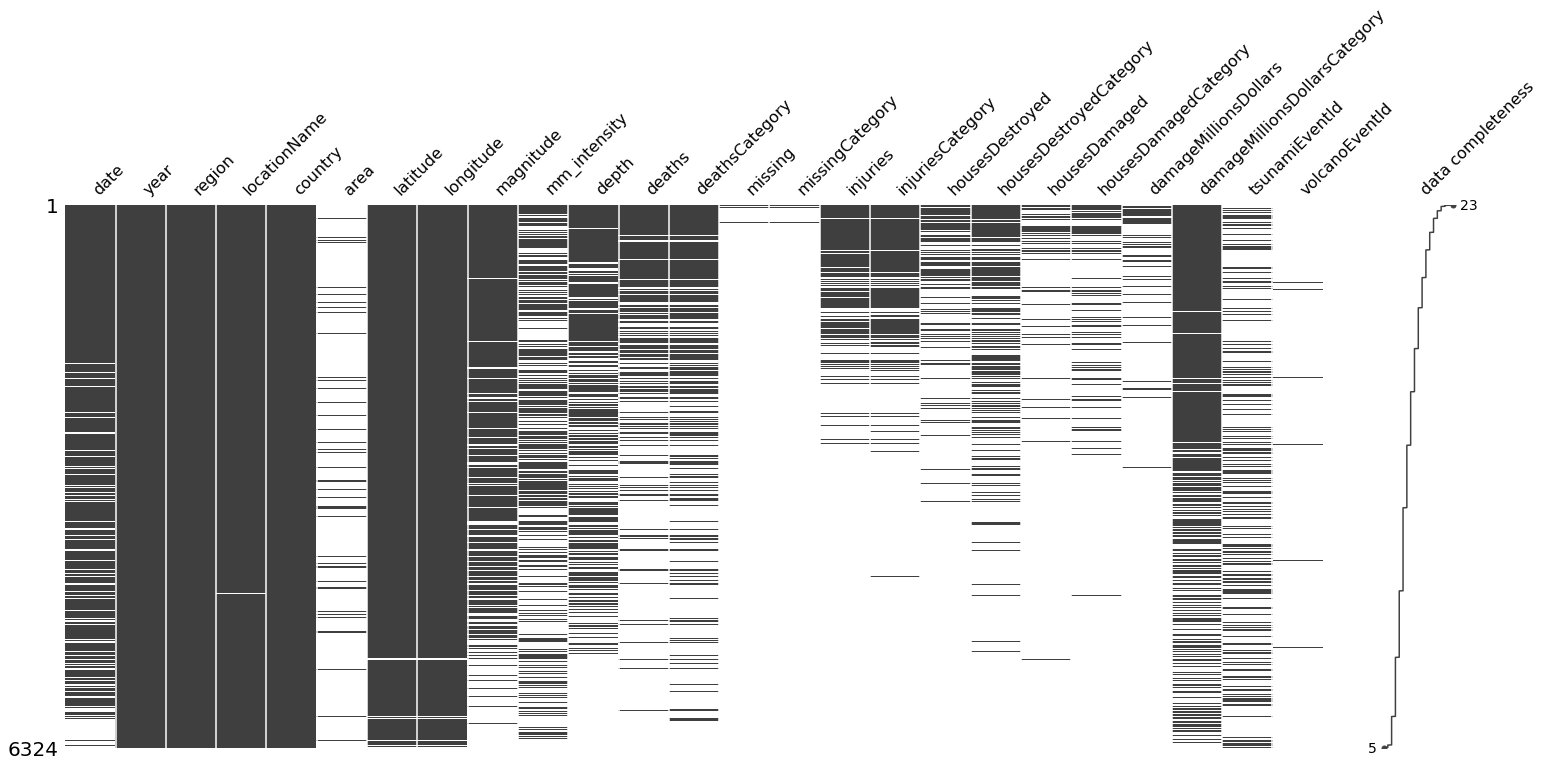

In [43]:
msno.matrix(eq, labels=True, sort='descending')

Lots of missing data! Are any of the missing points correlated?

<AxesSubplot:>

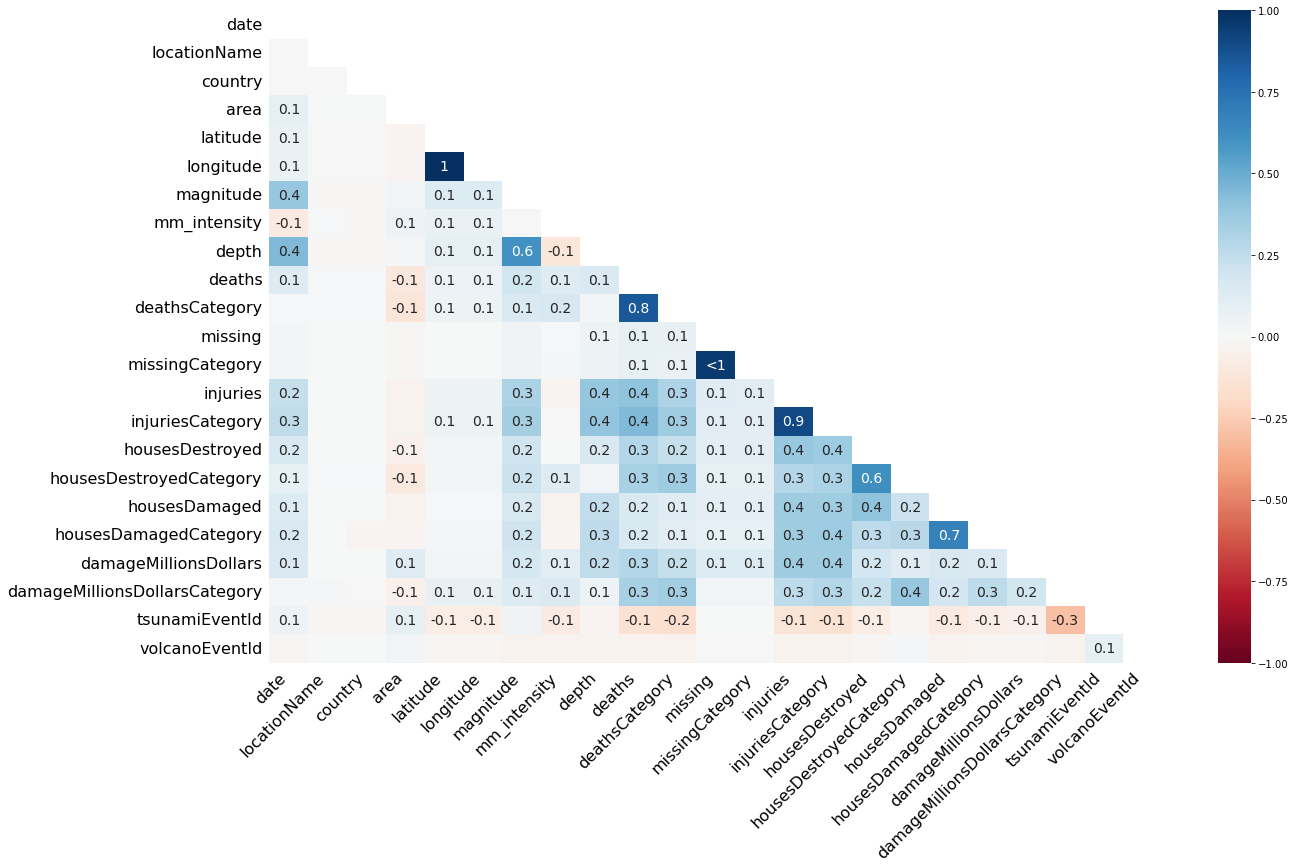

In [44]:
msno.heatmap(eq)

High positive correlation between e.g. 'deaths' and 'deathsCategory' missing value as one would expect.

The correlation between e.g. 'magnitude' and 'date' missing values (as well as other positive correlations present) is presumably earthquakes from the non-modern era where little is known about them.

Before investigating rows with lots of missing data, check the number of missing values per feature.

In [45]:
def plot_missing_values_per_feature(df):
    df.isna().mean().sort_values().plot(kind='bar', figsize=(12,6))
    plt.ylabel('Proportion of missing values per feature')

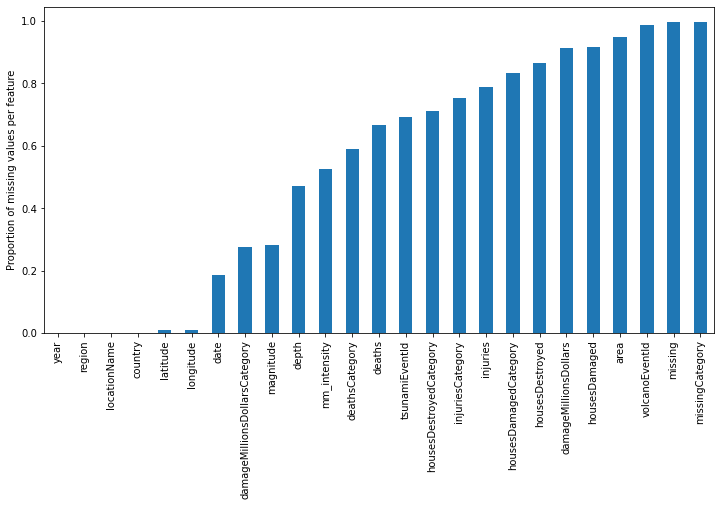

In [46]:
plot_missing_values_per_feature(eq)

Can I predict the number of houses damaged/destroyed based on location/magnitude/damage/depth/damage?

The area column can possibly be combined with region/locationName, as mentioned earlier.

Exact amount of damageMillionsDollars is missing in a large number of cases but the damageMillionsDollarsCategory does not have too many missing points.

Will try to fill some of the missing data points as described above. Drop the features where there are too many missing or if a different category provides a better measurement of a similar feature.

In [47]:
# Drop features with too many missing datapoints
eq.drop(['missing', 'missingCategory', 'damageMillionsDollars'], axis=1, inplace=True)
# Also drop 'mm_intensity' as 'magnitude' provides a similar measurement and has far fewer missing points
eq.drop('mm_intensity', axis=1, inplace=True)

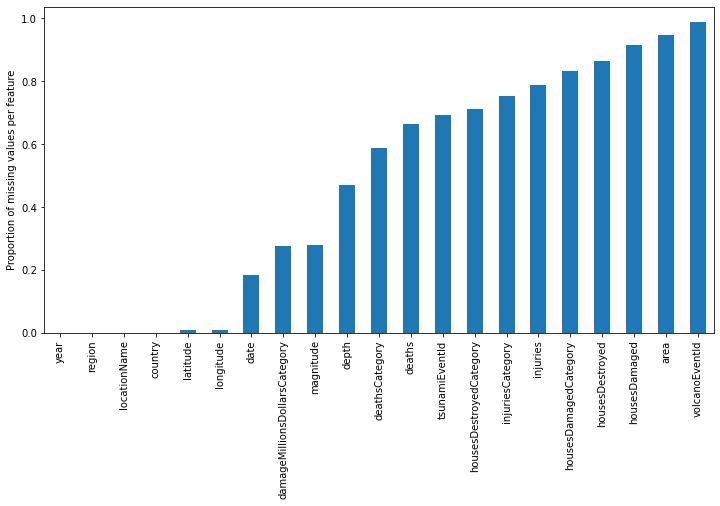

In [48]:
# Check missing values per feature
plot_missing_values_per_feature(eq)

In [49]:
# Entries with no tsunami and volcano event ID mean neither occured. Replace with 0/1 depending on if a secondary event occured
# or not
eq['caused_tsunami'] = eq['tsunamiEventId'].apply(lambda x: 0 if np.isnan(x) else 1)
eq['caused_volcano'] = eq['volcanoEventId'].apply(lambda x: 0 if np.isnan(x) else 1)
eq.drop(['tsunamiEventId', 'volcanoEventId'], axis=1, inplace=True)

In [50]:
eq.columns

Index(['date', 'year', 'region', 'locationName', 'country', 'area', 'latitude',
       'longitude', 'magnitude', 'depth', 'deaths', 'deathsCategory',
       'injuries', 'injuriesCategory', 'housesDestroyed',
       'housesDestroyedCategory', 'housesDamaged', 'housesDamagedCategory',
       'damageMillionsDollarsCategory', 'caused_tsunami', 'caused_volcano'],
      dtype='object')

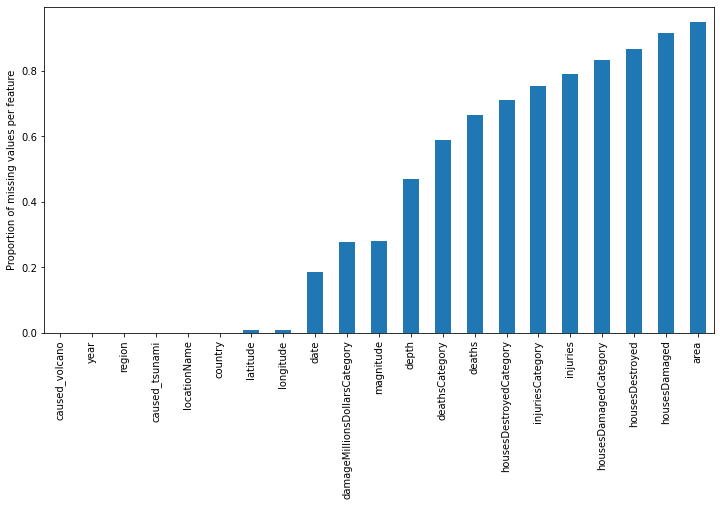

In [51]:
# Check missing values per feature
plot_missing_values_per_feature(eq)

In [52]:
# What dates are missing?
eq[eq['date'].isna()]

,date,year,region,locationName,country,area,latitude,longitude,magnitude,depth,...,deathsCategory,injuries,injuriesCategory,housesDestroyed,housesDestroyedCategory,housesDamaged,housesDamagedCategory,damageMillionsDollarsCategory,caused_tsunami,caused_volcano
id,,,,,,,,,,,,,,,,,,,,,
40,NaT,17,Middle East,"TURKEY: IZMIR, EFES, AYDIN, MANISA, ALASEHIR,...",TURKEY,NaN,37.850,27.300,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,0
49,NaT,52,Southern Europe,"GREECE: PHILIPPI,DRAMA,KAVALA",GREECE,NaN,41.000,24.300,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,0
58,NaT,79,Southern Europe,ITALY: NAPLES (NAPOLI),ITALY,NaN,40.821,14.426,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
61,NaT,93,Middle East,TURKEY: HELLESPONT,TURKEY,NaN,40.600,26.700,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,0
66,NaT,138,East Asia,CHINA: GANSU PROVINCE,CHINA,NaN,35.800,103.500,6.8,NaN,...,3.0,NaN,NaN,NaN,3.0,NaN,NaN,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9947,NaT,1255,S. and SE. Asia and Indian Ocean,NEPAL: KATHMANDU,NEPAL,NaN,27.700,85.300,NaN,NaN,...,3.0,NaN,NaN,NaN,3.0,NaN,NaN,3.0,0,0
9969,NaT,120,Middle East,"TURKEY: NICOMEDIA, NICAEA",TURKEY,NaN,40.770,29.920,7.2,NaN,...,3.0,NaN,NaN,NaN,3.0,NaN,NaN,2.0,1,0
10066,NaT,1831,Central and South Pacific,NEW ZEALAND: NORTH ISLAND: POVERTY BAY,NEW ZEALAND,NaN,-38.700,178.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [53]:
eq[eq['date'].isna()]['year'].describe()

count    1171.000000
mean     1250.855679
std       589.516146
min     -2150.000000
25%      1011.500000
50%      1493.000000
75%      1641.000000
max      1957.000000
Name: year, dtype: float64

In [54]:
eq[eq['year'].isna()]

,date,year,region,locationName,country,area,latitude,longitude,magnitude,depth,...,deathsCategory,injuries,injuriesCategory,housesDestroyed,housesDestroyedCategory,housesDamaged,housesDamagedCategory,damageMillionsDollarsCategory,caused_tsunami,caused_volcano
id,,,,,,,,,,,,,,,,,,,,,


In [55]:
# On second thoughts, will likely gain more info from keeping year (inc. negative years) than dropping values that can't
# be converted to pd.datetime objects. So drop 'date' and keep 'year'.
eq.drop('date', axis=1, inplace=True)

In [56]:
# What about 'area'? This represents the US county code
eq[eq['area'].notnull()]

,year,region,locationName,country,area,latitude,longitude,magnitude,depth,deaths,deathsCategory,injuries,injuriesCategory,housesDestroyed,housesDestroyedCategory,housesDamaged,housesDamagedCategory,damageMillionsDollarsCategory,caused_tsunami,caused_volcano
id,,,,,,,,,,,,,,,,,,,,
1693,1825,Central and South Pacific,GUAM; NORTHERN MARIANA ISLANDS: LADRONES ISLAND,USA TERRITORY,GU,14.000,143.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.0,1,0
2419,1892,Central and South Pacific,GUAM,USA TERRITORY,GU,14.000,143.300,7.5,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0,1,0
2533,1898,North America and Hawaii,"CALIFORNIA: N COAST,MENDOCINO COUNTY",USA,CA,39.000,-124.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,0
2554,1899,North America and Hawaii,ALASKA: CAPE YAKATAGA,USA,AK,60.000,-140.000,7.8,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2606,1902,North America and Hawaii,ALASKA: ALEUTIAN ISLANDS: FOX ISLANDS,USA,AK,52.400,-167.500,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9954,1700,North America and Hawaii,CASCADIA SUBDUCTION ZONE,USA,OR,45.000,-125.000,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
10036,2013,North America and Hawaii,TEXAS: WEST,USA,TX,31.817,-97.088,2.1,0.0,14.0,1.0,200.0,3.0,50.0,1.0,NaN,NaN,4.0,0,0
10157,2015,North America and Hawaii,ALASKA,USA,AK,52.214,-169.399,6.9,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0


In [57]:
# We already have this information in 'locationName' and latitude/longitude so drop
eq.drop('area', axis=1, inplace=True)

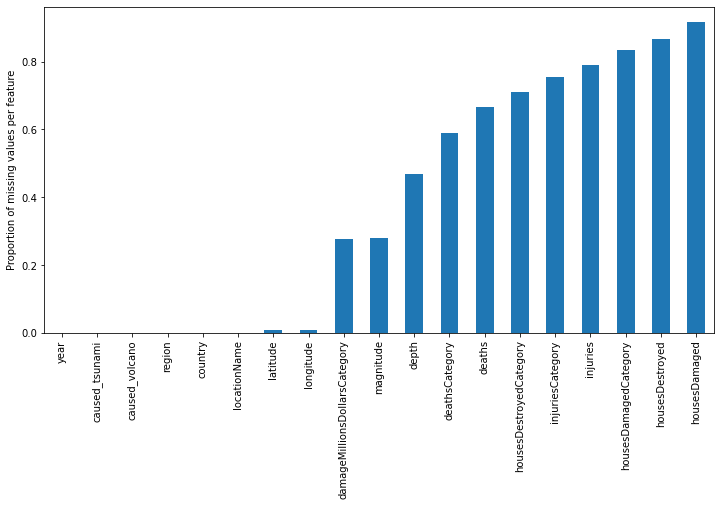

In [58]:
# Check missing values per feature
plot_missing_values_per_feature(eq)

In [59]:
# Realistically, too much missing data in below columns so drop
eq.drop(['housesDamaged', 'housesDestroyed', 'housesDamagedCategory', 'injuries', 'injuriesCategory', 'housesDestroyedCategory'],
       axis=1, inplace=True)

<AxesSubplot:>

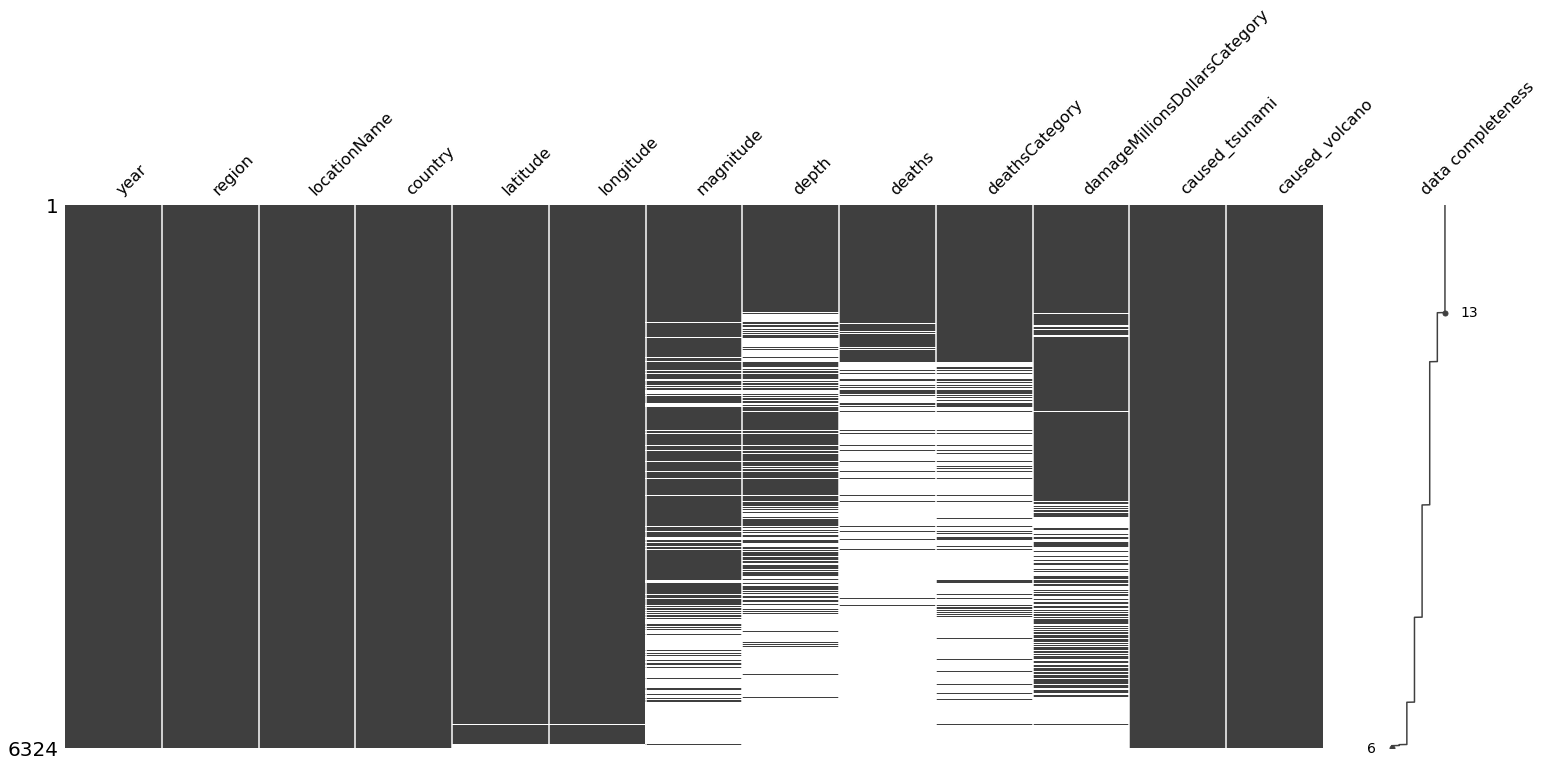

In [60]:
# Check missing data
msno.matrix(eq, labels=True, sort='descending')

<AxesSubplot:ylabel='Frequency'>

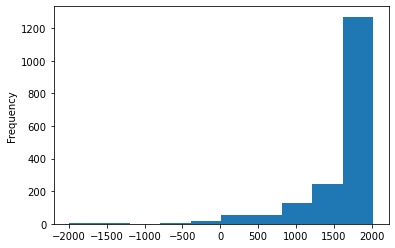

In [61]:
eq[eq['magnitude'].isnull()]['year'].plot(kind='hist')

In [62]:
# Drop entries where magnitude is missing, likely to be an important feature!
eq.drop(eq[eq['magnitude'].isnull()].index, inplace=True)

<AxesSubplot:>

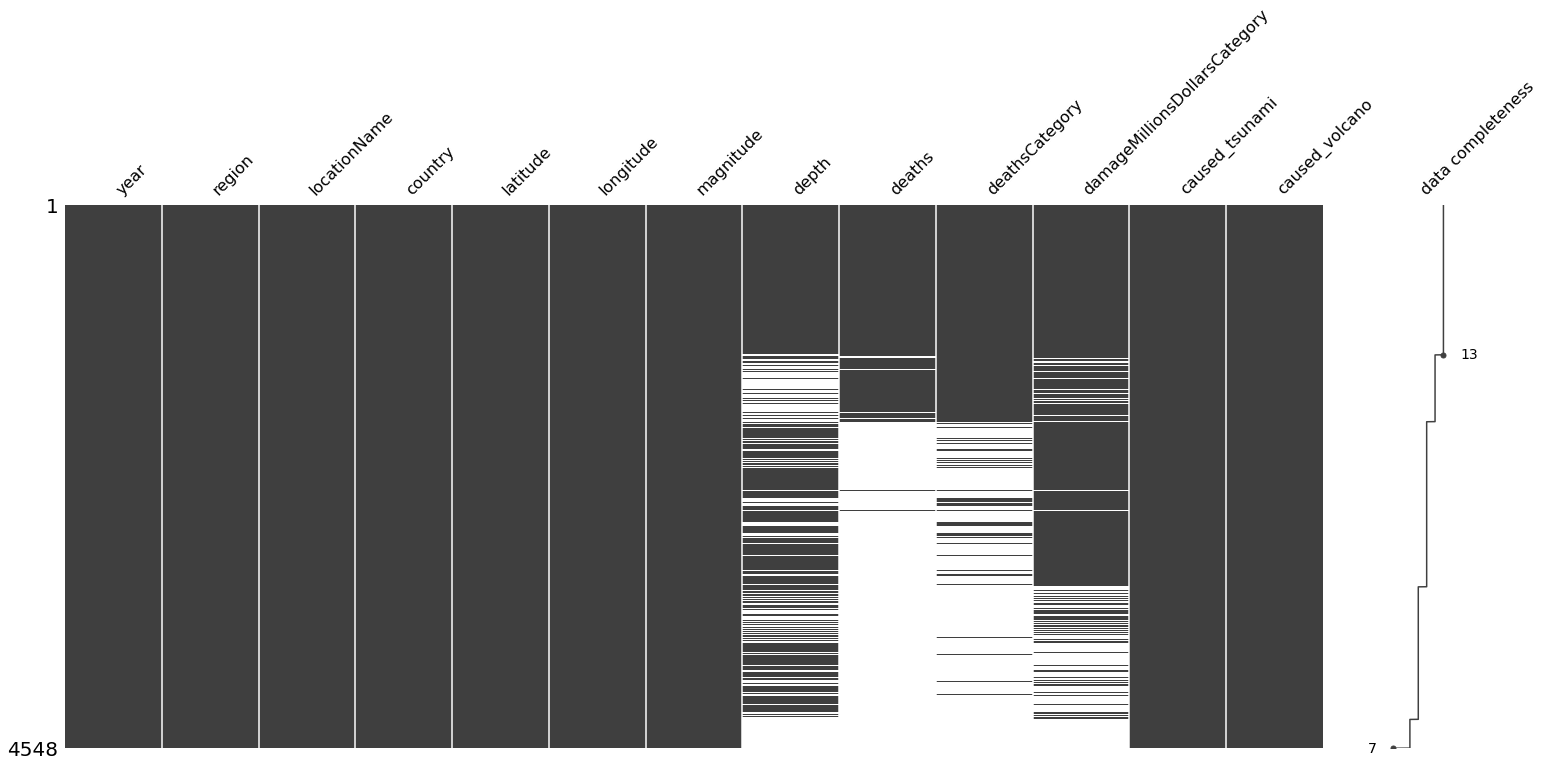

In [63]:
# Check missing data
msno.matrix(eq, labels=True, sort='descending')

Text(0, 0.5, 'depth')

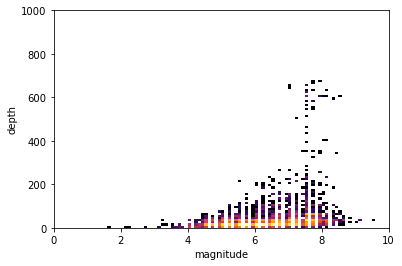

In [64]:
# Can the depth column missing values be filled based on the magnitude of the earthquake?
plt.hist2d(eq['magnitude'], eq['depth'], range=[[0,10],[0,1000]], bins=100, cmap='inferno', norm=colors.LogNorm())#, s=2)
plt.xlabel('magnitude')
plt.ylabel('depth')

In [65]:
# Although deeper earthquakes tend to be larger in magnitude, unlikely to be able to predict the shallower earthquakes well
# by only using magnitude.

In [66]:
def create_zoomed_violinplot(df, x, y):
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    sns.violinplot(data=df, x=x, y=y, ax=ax[0])
    sns.violinplot(data=eq, x=x, y=y, ax=ax[1])
    ax[1].set_ylim([-50,200])
    ax[1].text(0.3, 180, 'Zoomed version')

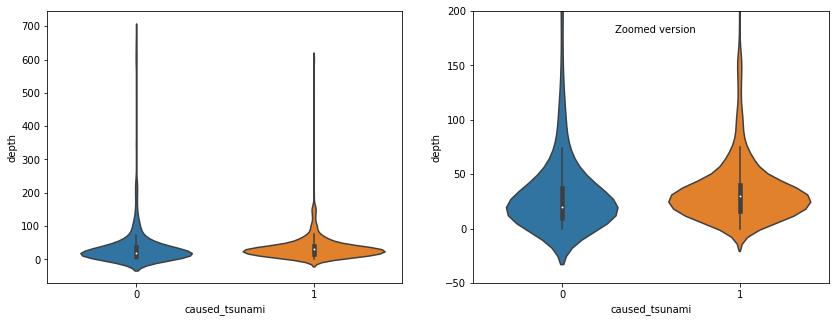

In [67]:
# Does whether a tsunami/volcano occured help predict depth?
create_zoomed_violinplot(eq, 'caused_tsunami', 'depth')

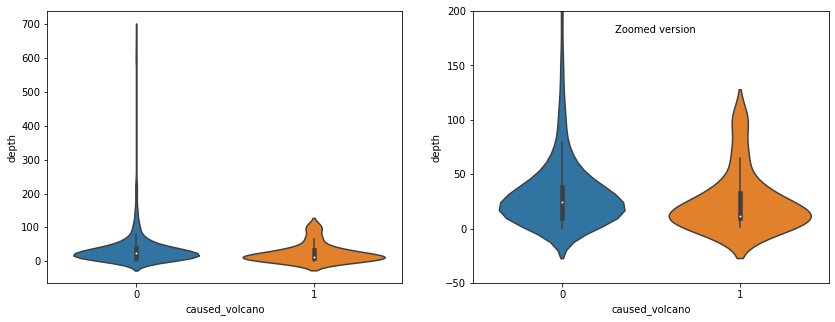

In [68]:
create_zoomed_violinplot(eq, 'caused_volcano', 'depth')

N.B. Negative values are an artifact of the KDEs used to create the violin plots, the depths aren't negative!

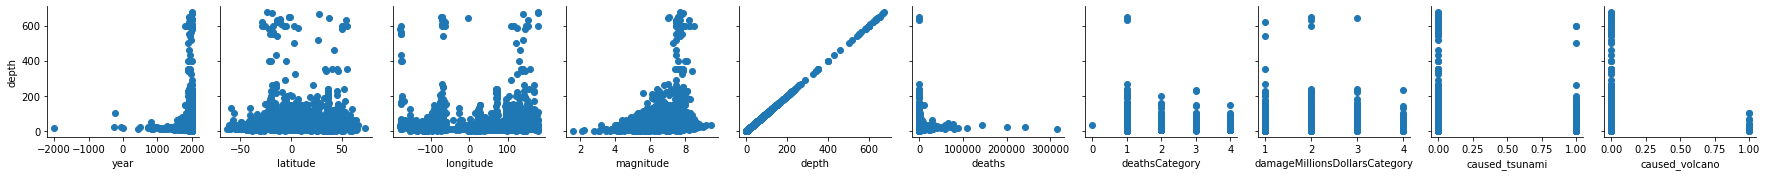

In [69]:
g = sns.PairGrid(eq, y_vars='depth')    
g = g.map(plt.scatter)

In [70]:
# No obvious variable that could be used to predict depth (some apparently strange features here, to be looked at later)
# Drop entries with depth missing
eq.drop(eq[eq['depth'].isnull()].index, inplace=True)

<AxesSubplot:>

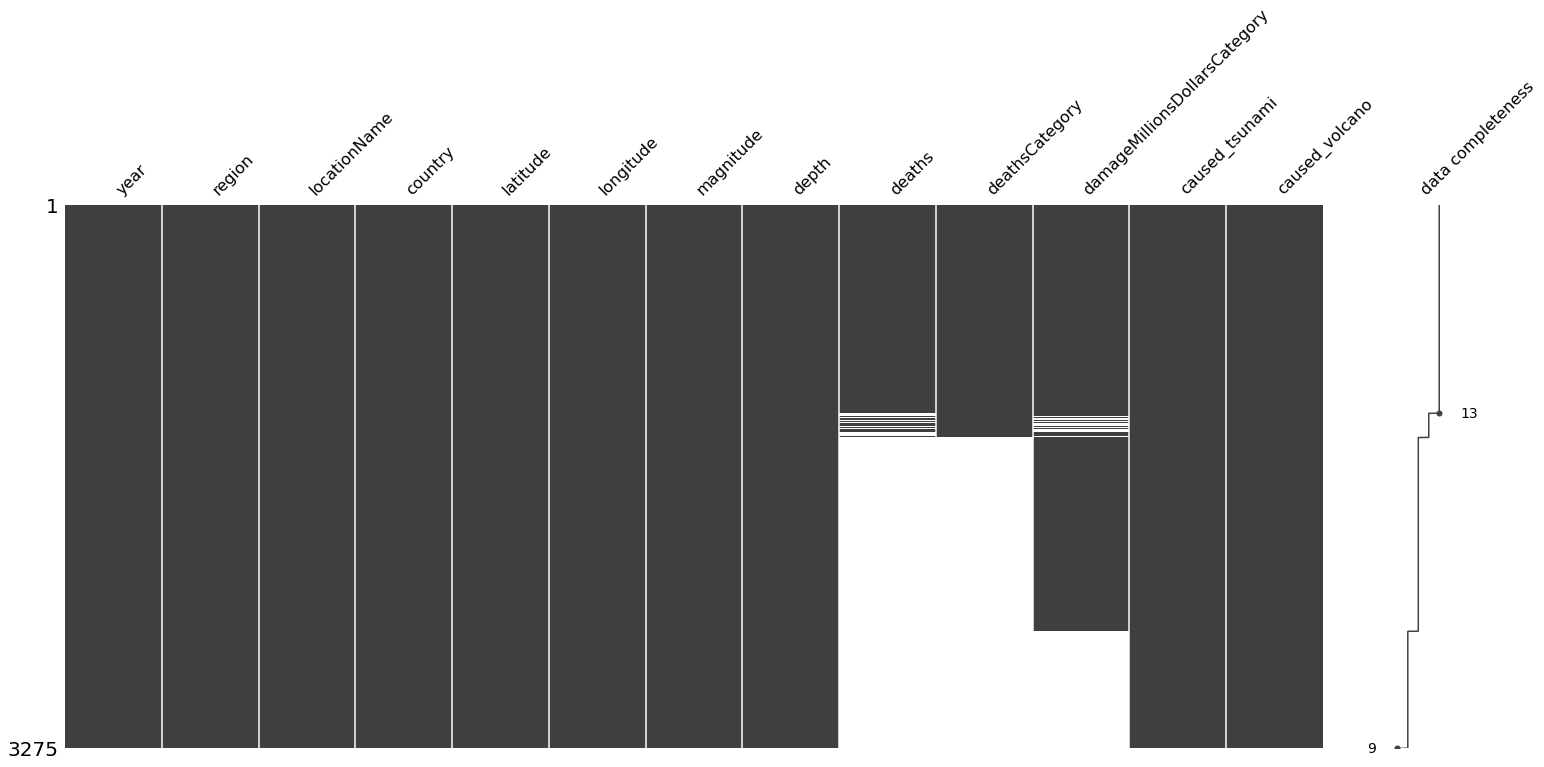

In [71]:
msno.matrix(eq, labels=True, sort='descending')

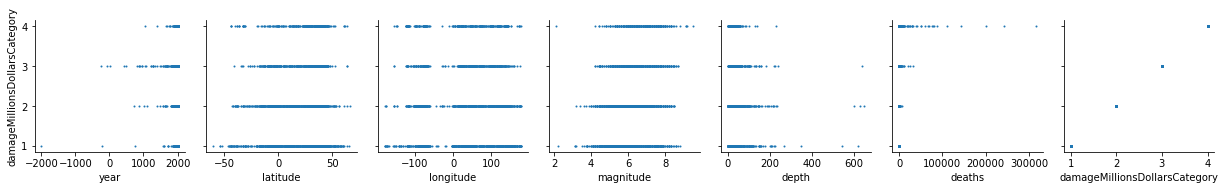

In [72]:
# Finally, what about the damageMillionsDollarsCategory?
g = sns.PairGrid(eq[['year', 'latitude', 'longitude', 'magnitude', 'depth', 'deaths', 'damageMillionsDollarsCategory']],
                 y_vars='damageMillionsDollarsCategory')
#g = g.map(plt.hist2d, norm=colors.LogNorm())#, s=2)
g = g.map(plt.scatter, s=1)

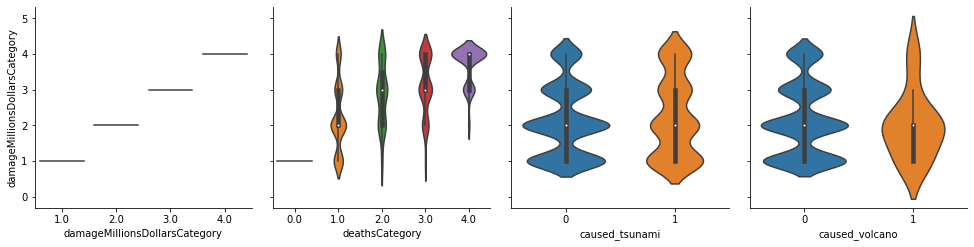

In [73]:
g = sns.PairGrid(eq[['damageMillionsDollarsCategory','deathsCategory', 'caused_tsunami', 'caused_volcano']],
                 y_vars='damageMillionsDollarsCategory', height=3.5)
g = g.map(sns.violinplot)

Text(0, 0.5, 'damageMillionsDollarsCategory')

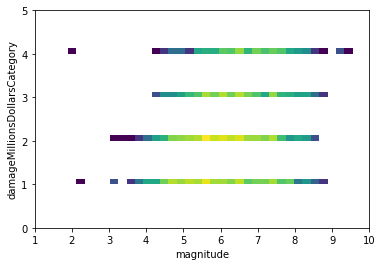

In [74]:
temp = plt.hist2d(eq['magnitude'], eq['damageMillionsDollarsCategory'], range=[[1,10],[0,5]], bins=40, norm=colors.LogNorm())
plt.xlabel('magnitude')
plt.ylabel('damageMillionsDollarsCategory')

In [75]:
# No easy way to fill the missing info from damageMillionsDollarsCategory. Drop missing entries
eq.drop(eq[eq['damageMillionsDollarsCategory'].isnull()].index, inplace=True)

<AxesSubplot:>

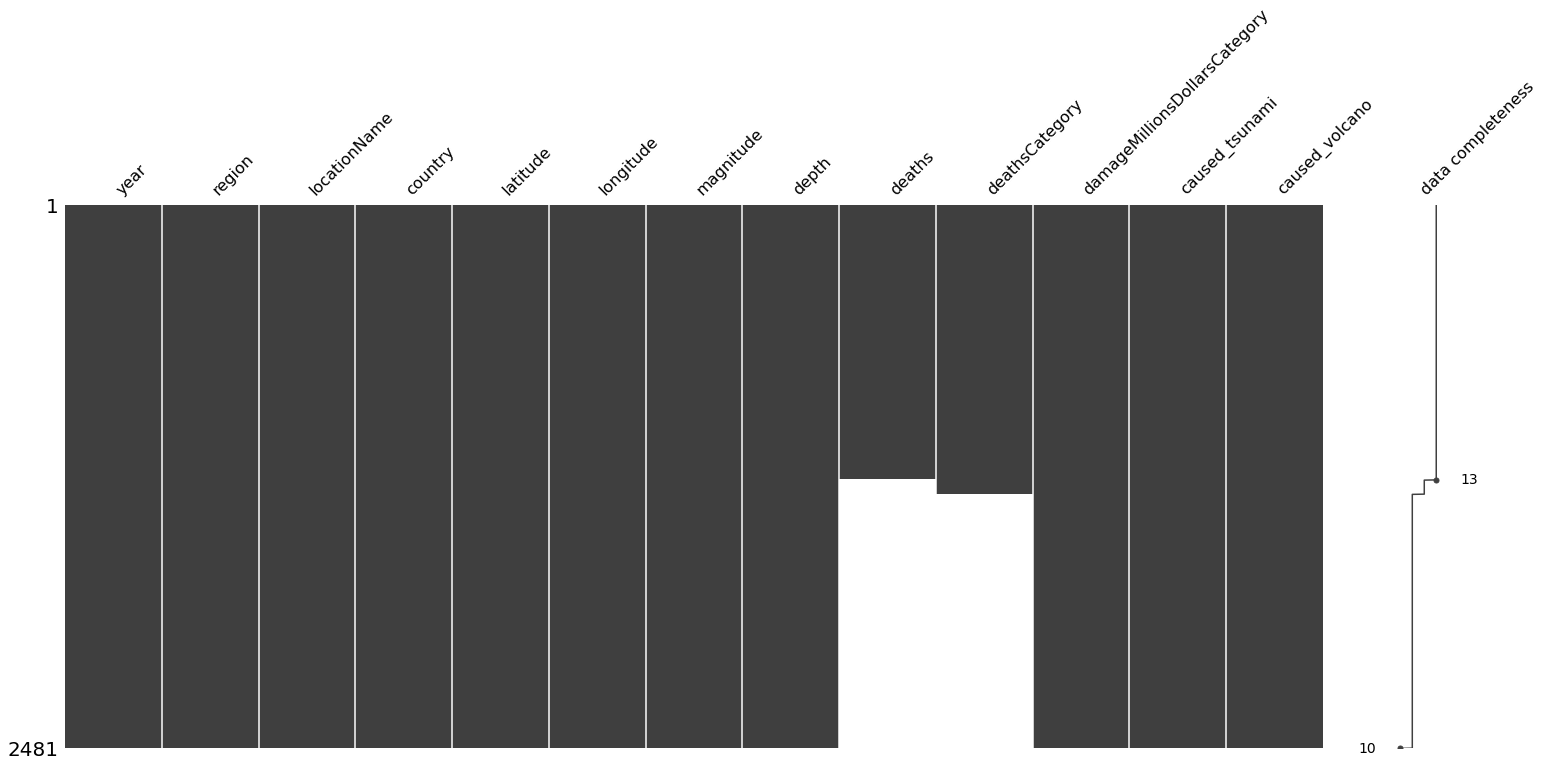

In [76]:
msno.matrix(eq, labels=True, sort='descending')

In [77]:
# Aiming to predict deaths so don't need to worry about missing data there (yet)

## Content

Try to understand the properties of each feature and the relationships between them.

In [78]:
#sns.pairplot(eq) # Hidden to reduce size of notebook (all plots can be seen individually below anyway)

<AxesSubplot:xlabel='year', ylabel='Count'>

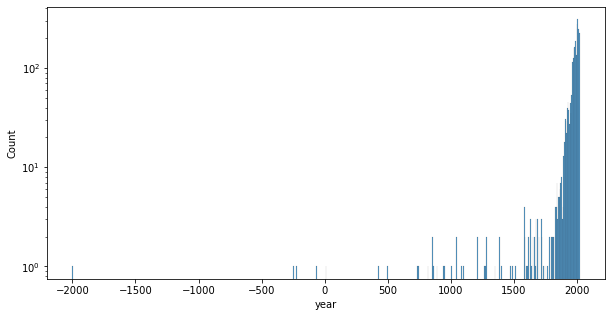

In [79]:
# Majority of recorded earthquakes were from ~1800 onwards
plt.figure(figsize=(10,5))
sns.histplot(data=eq, x='year', log_scale=(False,True))

In [80]:
# Location of each earthquake (colour=magnitude). Plot hidden to reduce size of notebook (and can't view on github anyway).
# As expected, they tend to lie along tectonic plates.
# Lack of recorded earthquakes around the Atlantic Ocean result in gaps in the data around longitude~-50 (see pairplot)
# fig = px.scatter_geo(eq, lat='latitude', lon='longitude', hover_name='year', color='magnitude')
# fig.update_layout(title='Earthquakes', title_x=0.5)
# fig.update_traces(marker=dict(size=2))
# fig.show()

In [197]:
# Earthquakes earlier than the year 1500 seem to be focussed around one region (central/western Asia). Plot hidden to reduce size of notebook (and can't view on github anyway).
# fig = px.scatter_geo(eq[eq['year']<1500], lat='latitude', lon='longitude', hover_name='year', color='magnitude')
# fig.update_layout(title='Earthquakes', title_x=0.5)
# fig.update_traces(marker=dict(size=5))
# fig.show()

In [82]:
# How many earthquakes are there per country? N.B. Need to combined USA and USA TERRITORY to obtain correct map below
eq['country'].replace('USA TERRITORY','USA').value_counts()

CHINA                                   237
INDONESIA                               214
IRAN                                    202
USA                                     131
JAPAN                                   119
                                       ... 
SWITZERLAND                               1
WALLIS AND FUTUNA (FRENCH TERRITORY)      1
LEBANON                                   1
BELGIUM                                   1
KENYA                                     1
Name: country, Length: 123, dtype: int64

In [83]:
fig = px.choropleth(locationmode='country names',
                    locations=eq['country'].replace('USA TERRITORY','USA').value_counts().rename(index={'USA': 'UNITED STATES'}).index,
                    color=eq['country'].replace('USA TERRITORY','USA').value_counts(),
                    color_continuous_scale=px.colors.sequential.Plasma,
                    hover_name=eq['country'].replace('USA TERRITORY','USA').value_counts().index
                   )
fig.show()

<AxesSubplot:xlabel='magnitude', ylabel='Count'>

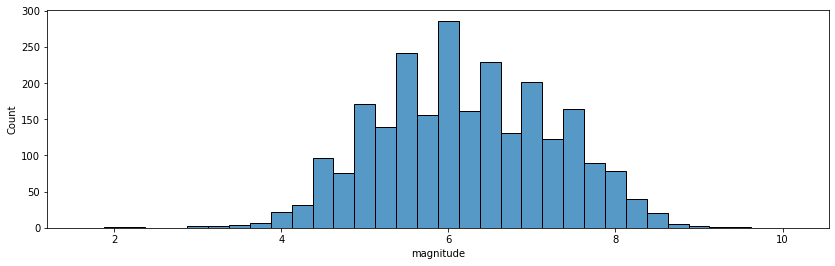

In [84]:
# Magnitude recordings in multiples of 0.5 most common. Approx. 6 is the most common magnitude.
plt.figure(figsize=(14,4))
sns.histplot(data=eq, x='magnitude', binwidth=0.25, binrange=(1.625,10))

<AxesSubplot:xlabel='damageMillionsDollarsCategory', ylabel='magnitude'>

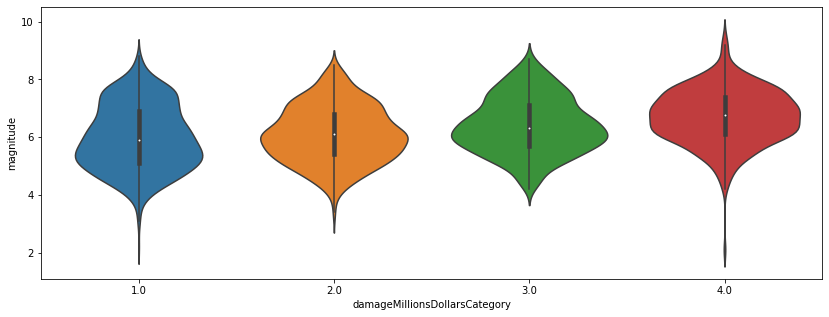

In [85]:
# Larger magnitude tends to lead to more damage, as expected
plt.figure(figsize=(14,5))
sns.violinplot(data=eq, x='damageMillionsDollarsCategory', y='magnitude')

<AxesSubplot:xlabel='depth', ylabel='Count'>

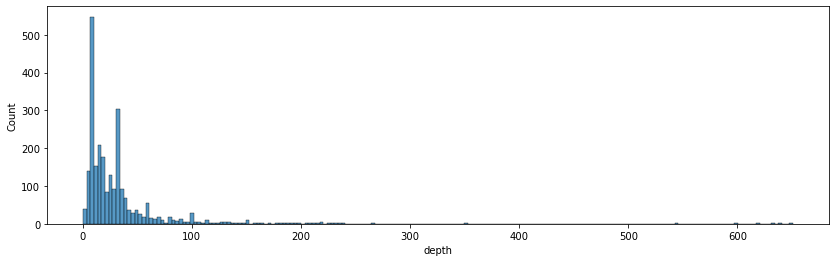

In [86]:
# Majority of earthquakes occur <100km from Earths surface
plt.figure(figsize=(14,4))
sns.histplot(data=eq, x='depth')

<AxesSubplot:xlabel='year', ylabel='depth'>

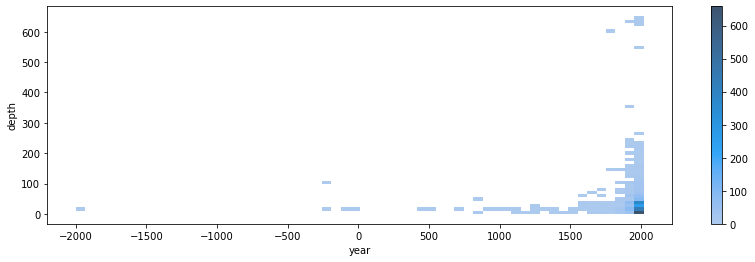

In [87]:
# Most earthquakes at shallow depths (which a quick Google confirms is the case)
plt.figure(figsize=(14,4))
sns.histplot(data=eq, x='year', y='depth', bins=60, cbar=True)

<AxesSubplot:xlabel='magnitude', ylabel='depth'>

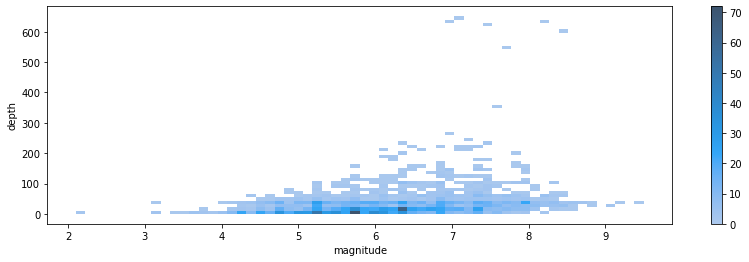

In [88]:
# Deeper earthquakes tend to be higher in magnitude
plt.figure(figsize=(14,4))
sns.histplot(data=eq, x='magnitude', y='depth', bins=60, cbar=True)

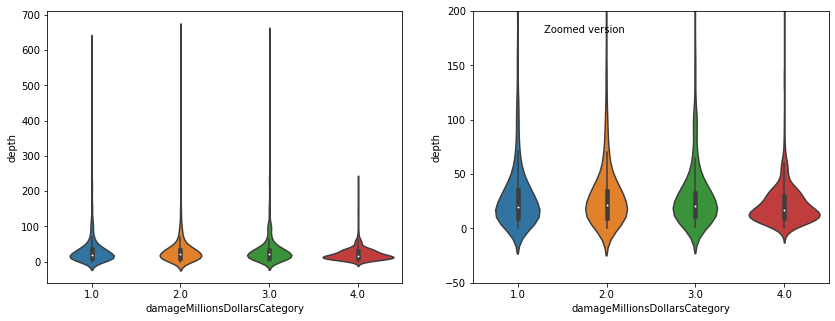

In [89]:
# No obvious relation between depth and damage
create_zoomed_violinplot(eq, 'damageMillionsDollarsCategory', 'depth')

<AxesSubplot:xlabel='damageMillionsDollarsCategory', ylabel='count'>

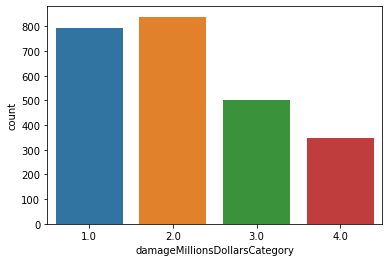

In [90]:
sns.countplot(data=eq, x='damageMillionsDollarsCategory')

In [91]:
# Earthquakes leading to tsunamis tend to occur in coastal/oceanic areas, as expected. Plot hidden to reduce notebook file size (can't view on github anyway).
# fig = px.scatter_geo(eq, lat='latitude', lon='longitude', hover_name='year', color='caused_tsunami')
# fig.update_layout(title='Earthquakes causing tsunamis', title_x=0.5)
# fig.update_traces(marker=dict(size=5))
# fig.show()

In [92]:
eq.columns

Index(['year', 'region', 'locationName', 'country', 'latitude', 'longitude',
       'magnitude', 'depth', 'deaths', 'deathsCategory',
       'damageMillionsDollarsCategory', 'caused_tsunami', 'caused_volcano'],
      dtype='object')

In [93]:
# Location of volcanoes can be seen (e.g. Mount Vesuvius in Italy, Hawaii islands...).  Plot hidden to reduce notebook file size (can't view on github anyway).
# Yellow markers made larger so they can be seen
# fig = px.scatter_geo(eq, lat='latitude', lon='longitude', hover_name='locationName', color='caused_volcano')
# fig.update_layout(title='Earthquakes causing volcanoes', title_x=0.5)
# fig.update_traces(marker=dict(size=(eq['caused_volcano']+1)*5))
# fig.show()

In [94]:
# Only 17 earthquakes in the dataset caused volcanoes
eq['caused_volcano'].value_counts()

0    2464
1      17
Name: caused_volcano, dtype: int64

<AxesSubplot:>

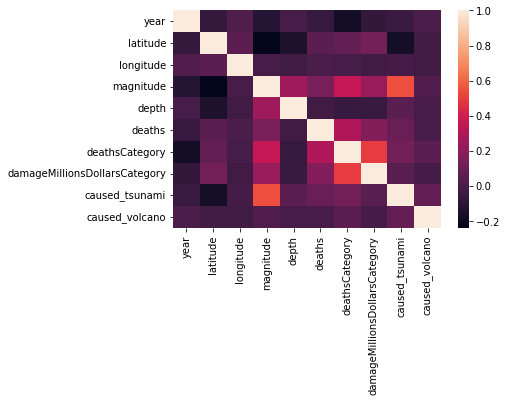

In [95]:
# Which data are correlated?
sns.heatmap(eq.corr())

- As demonstrated in earlier portion of EDA, magnitude is correlated with a lot of other features e.g. deaths, damage.
- Interestingly, but as expected, magnitude is highly correlated with whether a tsunami occured or not.
- Damage is slightly correlated with deaths.

### Target variable

<AxesSubplot:xlabel='deaths', ylabel='Count'>

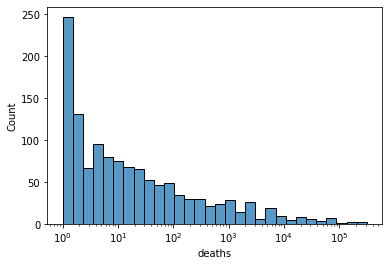

In [96]:
# Very few deaths in most earthquakes
sns.histplot(data=eq, x='deaths', bins=30, log_scale=True)

<AxesSubplot:xlabel='depth', ylabel='deaths'>

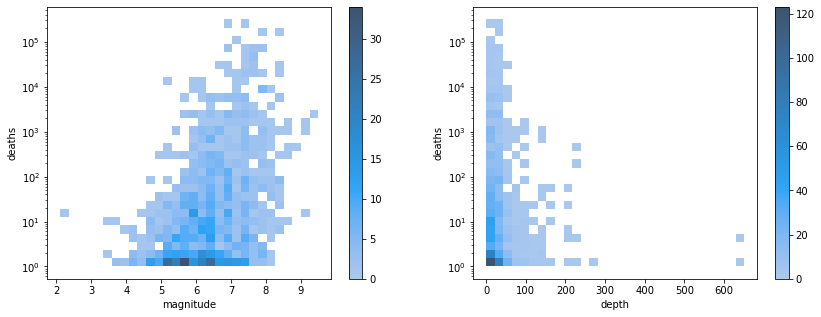

In [97]:
# Number of deaths tends to increase as magnitude increases
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.histplot(data=eq, y='deaths', x='magnitude', bins=30, log_scale=(False,True), cbar=True, ax=ax[0])
sns.histplot(data=eq, y='deaths', x='depth', bins=30, log_scale=(False,True), cbar=True, ax=ax[1])

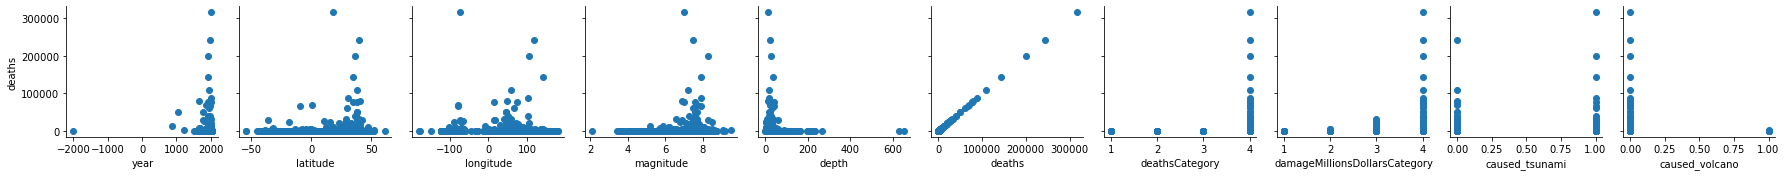

In [98]:
g = sns.PairGrid(eq, y_vars='deaths')
g = g.map(plt.scatter)

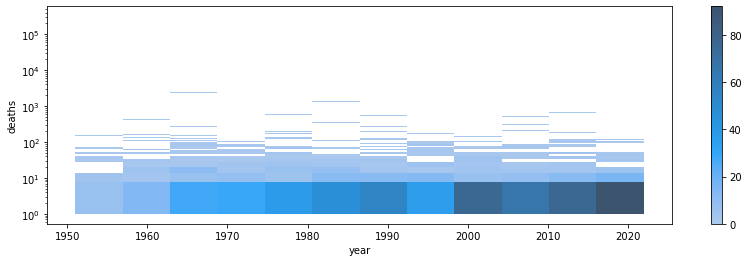

In [99]:
# More deaths as years go on? Simply just more/better recorded (only done most recent years due to lack of non-modern data)
plt.figure(figsize=(14,4))
sns.histplot(data=eq[eq['year']>1950], x='year', y='deaths',cbar=True)
plt.yscale('log')

<AxesSubplot:xlabel='deaths', ylabel='Count'>

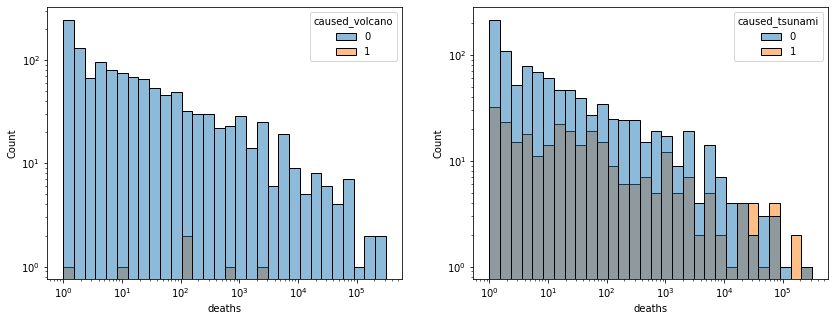

In [100]:
# Not enough data to judge whether volcano eruptions cause more deaths.
# Deaths follows similar trend for whether tsunami occurs or not.
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.histplot(data=eq, x='deaths', bins=30, log_scale=(True,True), hue='caused_volcano', ax=ax[0])
sns.histplot(data=eq, x='deaths', bins=30, log_scale=(True,True), hue='caused_tsunami', ax=ax[1])

In [101]:
eq.columns

Index(['year', 'region', 'locationName', 'country', 'latitude', 'longitude',
       'magnitude', 'depth', 'deaths', 'deathsCategory',
       'damageMillionsDollarsCategory', 'caused_tsunami', 'caused_volcano'],
      dtype='object')

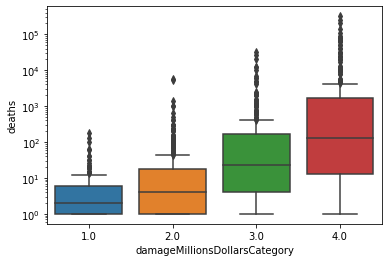

In [102]:
# As one would expect, more damage tends to lead to more deaths
sns.boxplot(data=eq, x='damageMillionsDollarsCategory', y='deaths')
plt.yscale('log')

In [103]:
people

,id,description
0,0,None
1,1,Few (~1 to 50 people)
2,2,Some (~51 to 100 people)
3,3,Many (~101 to 1000 people)
4,4,Very Many (~1001 or more people)


<AxesSubplot:xlabel='deathsCategory', ylabel='count'>

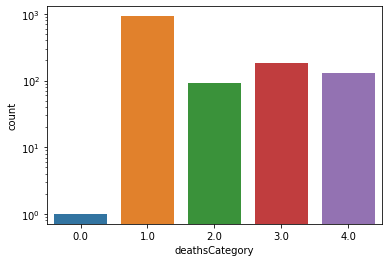

In [104]:
# Most earthquakes caused 1-50 deaths. Only 1 had zero deaths.
sns.countplot(data=eq, x='deathsCategory', log=True)

In [105]:
eq.head()

,year,region,locationName,country,latitude,longitude,magnitude,depth,deaths,deathsCategory,damageMillionsDollarsCategory,caused_tsunami,caused_volcano
id,,,,,,,,,,,,,
122,500,Central Asia and Caucasus,KAZAKHSTAN,KAZAKHSTAN,42.7,76.5,6.7,20.0,NaN,NaN,3.0,0,0
276,942,Central Asia and Caucasus,UZBEKISTAN: BUKHARA,UZBEKISTAN,39.7,64.5,6.7,20.0,NaN,NaN,3.0,0,0
464,1267,Middle East,IRAN: NEYSHABUR (NEISHABUR),IRAN,36.0,58.8,5.8,10.0,NaN,NaN,3.0,0,0
472,1275,Central Asia and Caucasus,GEORGIA,GEORGIA,42.1,44.2,6.7,28.0,NaN,3.0,3.0,0,0
481,1281,Middle East,IRAN: SHADIYAKH,IRAN,36.1,58.8,5.8,10.0,NaN,NaN,3.0,0,0


## Feature engineering

A useful feature to have would be the population density around the region of the earthquake. Ideally we would have this as a function of:
- The latitude/longitude of the earthquake
- The year that the earthquake occured

This data is available from the EU Global Human Settlement Layer (GHSL) project (full citation below): https://ghsl.jrc.ec.europa.eu/ghs_pop2019.php

The data I'm interested in is the population density measured in square tiles across the earth, each 30 arcseconds of latitude/longitude across (1 arcsecond = 1/3600 degrees which is approx. 30m on the Earths surface). Higher resolution is available but is not possible or suitable, as will be shown below.

The data was measured at four points in time: 1975, 1990, 2000, 2015. However, due to the very high resolution of the dataset, the file sizes are large and my local machine does not have the hardware capabilities to handle them all. I will hence be assuming that the population density is constant over time and will be using the most recent years (2015) data only.

**Full dataset citation**

Dataset:

Schiavina, Marcello; Freire, Sergio; MacManus, Kytt (2019): GHS population grid multitemporal (1975, 1990, 2000, 2015) R2019A. European Commission, Joint Research Centre (JRC) DOI: 10.2905/42E8BE89-54FF-464E-BE7B-BF9E64DA5218 PID: http://data.europa.eu/89h/0c6b9751-a71f-4062-830b-43c9f432370f

Concept & Methodology:

Freire, Sergio; MacManus, Kytt; Pesaresi, Martino; Doxsey-Whitfield, Erin; Mills, Jane (2016): Development of new open and free multi-temporal global population grids at 250 m resolution. Geospatial Data in a Changing World; Association of Geographic Information Laboratories in Europe (AGILE). AGILE 2016. 

<AxesSubplot:xlabel='year', ylabel='Count'>

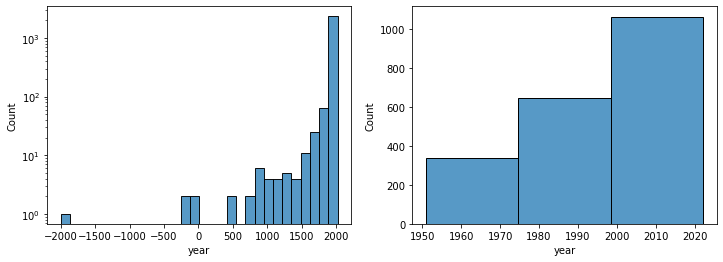

In [106]:
# Below plots show why 2015 dataset was chosen - majority of recorded earthquakes are in recent years.
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(data=eq, x='year', bins=30, cbar=True, log_scale=(False,True), ax=ax[0])
sns.histplot(data=eq[eq['year']>1950], x='year', bins=3, cbar=True, ax=ax[1])

In [107]:
# GHSL dataset is in the form of a .tif file
from tifffile import tifffile

In [108]:
# Data read into numpy array. Each element represents a tile on the earths surface.
pop_density = tifffile.imread('data/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0/GHS_POP_E2015_GLOBE_R2019A_4326_30ss_V1_0.tif')

In [109]:
pop_density.shape

(21600, 43200)

In [110]:
360/pop_density.shape[1] # 43200 tiles around the earths circumference (360 degrees), each equal to 30arcseconds

0.008333333333333333

In [111]:
30/3600 # 30 arcseconds in degrees (equal to above)

0.008333333333333333

In [112]:
pop_density.min()

-200.0

In [113]:
# Tiles with missing population density have entry set to -200.
# From GHSL website (https://ghsl.jrc.ec.europa.eu/download.php?ds=pop), missing tiles are all in the sea.
# Hence safe to assume that these can be approximated to have zero population density.
pop_density[pop_density==-200] = 0 # Replace -200 with zero

In [114]:
pop_density.min()

0.0

In [115]:
pop_density.max()

459434.619140625

As mentioned above, dataset is very high resolution (each tile is ~1km across). This is unsuitable for analysis of earthquakes because the effects are felt across O(10 - 100 km) rather than O(1km). Hence reshape the dataset by combining neighbouring tiles.

Tiles will now be ~10km (300 arcseconds) across.

In [116]:
H,W = 2160,4320 # block-size (10km per tile)
#H,W = 216,432 # block-size ()
#H,W = 108,216 # block-size (180km per tile)
#H,W = 54,108 # block-size
#H,W = 27,54 # block-size (720km per tile)
#H,W = 108, 216
m,n = pop_density.shape
low_res_pop_density = pop_density.reshape(H,m//H,W,n//W).sum(axis=(1,3))

In [117]:
# Delete original pop_density array to free up memory
import gc
del pop_density
gc.collect()

20078

In [118]:
low_res_pop_density.shape

(2160, 4320)

Text(33.0, 0.5, 'Tile index (latitude)')

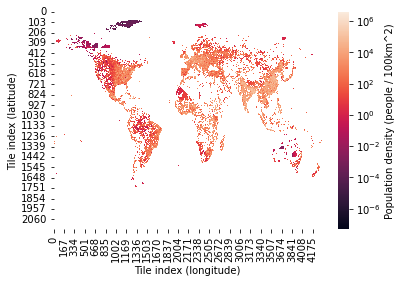

In [119]:
sns.heatmap(low_res_pop_density, norm=colors.LogNorm(), cbar_kws={'label': 'Population density (people / 100km^2)'})
plt.xlabel('Tile index (longitude)')
plt.ylabel('Tile index (latitude)')

Text(0, 0.5, 'Population density (summed over longitude)')

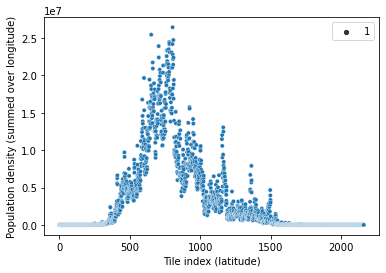

In [120]:
# Most of the population is in the northern hemisphere, as expected
sns.scatterplot(x=range(0,low_res_pop_density.shape[0]), y=low_res_pop_density.sum(axis=1), size=1)
plt.xlabel('Tile index (latitude)')
plt.ylabel('Population density (summed over longitude)')

Text(0, 0.5, 'Population density (summed over latitude)')

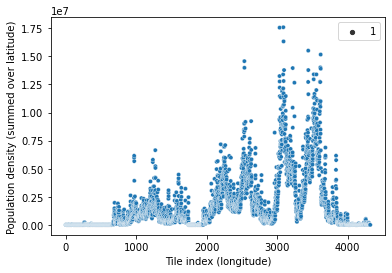

In [121]:
# Major spikes from USA, Europe, India and China
sns.scatterplot(x=range(0,low_res_pop_density.shape[1]), y=low_res_pop_density.sum(axis=0), size=1)
plt.xlabel('Tile index (longitude)')
plt.ylabel('Population density (summed over latitude)')

Now that we have the population density, we need to match each earthquake to a tile on the earths surface using the latitude/longitude.

In [122]:
n_long_tiles = low_res_pop_density.shape[1] # Number of tiles along longitudinal direction
n_lat_tiles = low_res_pop_density.shape[0] # Number of tiles along latitudinal (is that a word?) direction

In [123]:
# Find tile boundaries in longitudinal direction (-180 degrees to 180 degrees according to documentation)
long_tile_boundaries = np.array([-180])
for i in range(1,n_long_tiles):
    long_tile_boundaries = np.append(long_tile_boundaries, long_tile_boundaries[i-1] + (360/n_long_tiles))
long_tile_boundaries = np.append(long_tile_boundaries, 180)
long_tile_boundaries

array([-180.        , -179.91666667, -179.83333333, ...,  179.83333333,
        179.91666667,  180.        ])

In [124]:
# Do the same in the latitudinal direction (-56.37 degrees to 83.63 degrees according to documentation)
lat_tile_boundaries = np.array([83.63])
for i in range(1,n_lat_tiles):
    lat_tile_boundaries = np.append(lat_tile_boundaries, lat_tile_boundaries[i-1] - ((83.63--56.37)/n_lat_tiles))
lat_tile_boundaries = np.append(lat_tile_boundaries, -56.37)
lat_tile_boundaries

array([ 83.63      ,  83.56518519,  83.50037037, ..., -56.24037037,
       -56.30518519, -56.37      ])

(-1.0, 2.0)

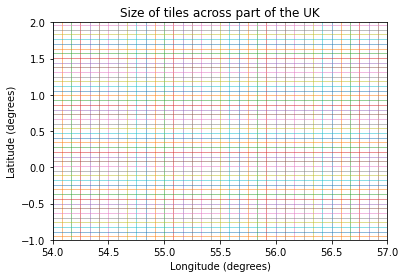

In [125]:
# Draw some of the tile boundaries (area chosen = small part of UK) - used to test code later.
for b in np.nditer(long_tile_boundaries[(long_tile_boundaries>54) & (long_tile_boundaries<57)]):
    plt.plot([b,b],[-56.37,83.63], linewidth=0.5)
for b in np.nditer(lat_tile_boundaries[(lat_tile_boundaries>-1) & (lat_tile_boundaries<2)]):
    plt.plot([-180,180], [b,b], linewidth=0.5)

plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Size of tiles across part of the UK')
plt.xlim([54,57])
plt.ylim([-1,2])

As I have discrete tiles in the population density dataset but we have continuous longitude/latitude coordinates for each earthquake, I need to find which tile each earthquake occured in.

This is almost a nearest neighbour problem except I need to make sure the earthquake position is greater than the nearest tile boundary and if not, use the previous tile. This makes sure the earthquake location is placed in the correct tile.

Due to this condition, a KDTree won't work and a custom function is needed.

In [126]:
def find_index_of_nearest_boundary(pos, boundary_array):
    """
    Given a position (either longitude or latitude), find the population density tile (on earths surface) it lies within.
    """
    distance = abs(boundary_array-pos) # absolute distance from all tile boundaries to position
    idx = np.where(distance==distance.min()) # index of tile with minimum distance to position
    if pos-boundary_array[idx[0][0]] < 0:
        idx[0][0] -= 1 # pos is to the left of/above boundary so go to previous tile
    return idx[0][0]

In [127]:
# Test function using certain longitude/latitudes (see plot above for reference)
find_index_of_nearest_boundary(55.02, long_tile_boundaries)

2820

In [128]:
find_index_of_nearest_boundary(54.98, long_tile_boundaries) # KDTree would return 2820 here which would be wrong

2819

In [129]:
find_index_of_nearest_boundary(0.0, lat_tile_boundaries)

1289

In [130]:
find_index_of_nearest_boundary(0.05, lat_tile_boundaries)

1290

Can now apply above function to the earthquake dataset to find which tile each earthquake occured in.

In [131]:
# Find longitudinal tile
eq['long_tile'] = eq['longitude'].apply(find_index_of_nearest_boundary, args=(long_tile_boundaries,)) # args must be tuple

In [132]:
eq['long_tile']

id
122      3077
276      2933
464      2865
472      2690
481      2865
         ... 
10494    3399
10557    3006
10617    1237
10627    3395
10640    3609
Name: long_tile, Length: 2481, dtype: int64

In [133]:
# Find latitudinal tile
eq['lat_tile'] = eq['latitude'].apply(find_index_of_nearest_boundary, args=(lat_tile_boundaries,)) # args must be tuple

In [134]:
eq['lat_tile']

id
122       630
276       678
464       735
472       641
481       732
         ... 
10494     868
10557     688
10617    1481
10627     820
10640    1018
Name: lat_tile, Length: 2481, dtype: int64

Now that we have the tile each earthquake occurs in, can find the population density of that tile and hence match it to an earthquake.

However, most of the tiles have zero population density. Can see this in the heatmap above but also:

In [135]:
low_res_pop_density.shape

(2160, 4320)

In [136]:
2160*4320 # = 9331200 tiles

9331200

In [137]:
np.unique(low_res_pop_density, return_counts=True)

(array([0.00000000e+00, 4.74519979e-08, 9.49039958e-08, ...,
        3.22594581e+06, 3.61550971e+06, 3.88642190e+06]),
 array([8383107,      13,      12, ...,       1,       1,       1],
       dtype=int64))

In [138]:
# Of these 9331200 tiles, 8383107 have zero population density. This is expected as most of the earths surface is water.
# Interestingly, this also implies that only (1. - 8383107/9331200) = 11% of the earths surface is lived on by humans!
# From a quick google, this seems to be about right.

Because of this, if an earthquake occured in a tile with zero population density, I will find the nearest tile that doesn't have a non-zero population density and use that instead.

Two alternative options to be investigated in the future:
- Use larger tiles (e.g. 100x100km) instead.
- Calculate the sum of the population densities in nearby tiles where "nearby" is defined by a circle of an appropriate radius, centred at the latitude and longitude of the earthquake.

In [139]:
def nearest_nonzero_idx(a,ix,iy):
    """
    For an index (ix,iy), finds the index of the nearest non-zero element in 2D array 'a' if the element at (ix,iy) is zero.
    e.g. for index (0,0), the nearest non-zero element in the array below is 2 which is at index (1,2).
    [[0,0,0,3]
     [0,0,2,1]
     [0,0,0,0]]
    """
    idx = np.argwhere(a) # obtains indices of non-zero elements
        
    sq_distance_to_nonzero = ((idx - [ix,iy])**2).sum(axis=1) # squared distance across array in "index units"
    closest_nonzero_index = sq_distance_to_nonzero.argmin() # index of minimum distance
    return idx[closest_nonzero_index]

In [140]:
# Test above function
nearest_nonzero_idx(np.array([[0,0,3],[4,5,6]]), 0, 0)

array([1, 0], dtype=int64)

In [141]:
def find_pop_density(long_idx, lat_idx):
    """
    Given the longitudinal and latitudal index of a certain tile, return the population density for that tile.
    If the tiles population density is zero, returns the nearest non-zero population density instead.
    """
    if int(low_res_pop_density[lat_idx,long_idx])==0:
        # Find nearest non-zero population density
        nearest_nonzero_pop = nearest_nonzero_idx(low_res_pop_density,lat_idx,long_idx)
        return low_res_pop_density[nearest_nonzero_pop[0],nearest_nonzero_pop[1]]
    else:
        return low_res_pop_density[lat_idx,long_idx]

In [142]:
low_res_pop_density[0,0] # Actual population density in top left tile

0.0

In [143]:
find_pop_density(0,0) # Nearest non-zero population density to top left tile

163.40229511260986

In [144]:
# Apply function to earthquake dataframe to find population density near the earthquakes location
eq['pop_dens'] = eq.apply(lambda x: find_pop_density(x['long_tile'], x['lat_tile']), axis=1)

In [145]:
# Drop unneeded columns
eq.drop(['lat_tile','long_tile'], axis=1, inplace=True)

In [146]:
# mean is about 4850 people/100km^2; median is much less at 127 people/100km^2
eq['pop_dens'].describe()

count    2.481000e+03
mean     4.840605e+03
std      3.569950e+04
min      2.769017e-05
25%      1.387366e+01
50%      1.265227e+02
75%      1.299656e+03
max      1.643222e+06
Name: pop_dens, dtype: float64

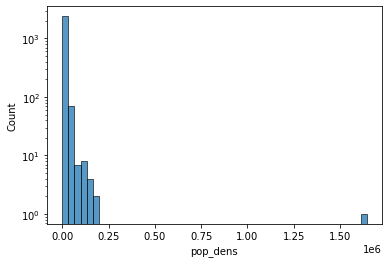

In [147]:
sns.histplot(data=eq, x='pop_dens', bins=50)
plt.yscale('log')

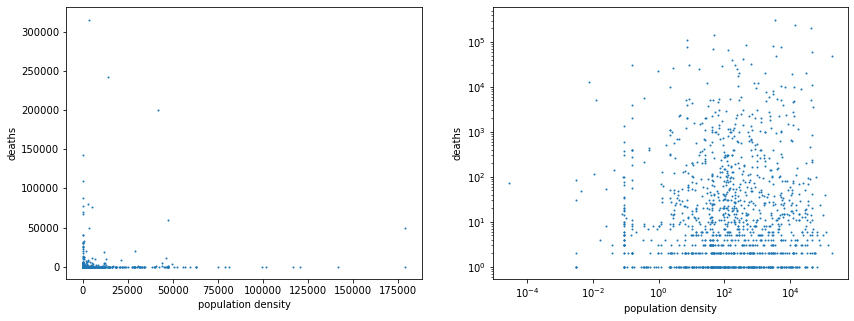

In [148]:
# There are some very large and some very small population densities. These could be dropped as outliers in future.
# No obvious trend between deaths and population density at first glance however.
fig, ax = plt.subplots(1,2, figsize=(14,5))
for a in ax:
    a.scatter(x=eq['pop_dens'],y=eq['deaths'],s=1)
    a.set_xlabel('population density')
    a.set_ylabel('deaths')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

<AxesSubplot:xlabel='pop_dens', ylabel='deaths'>

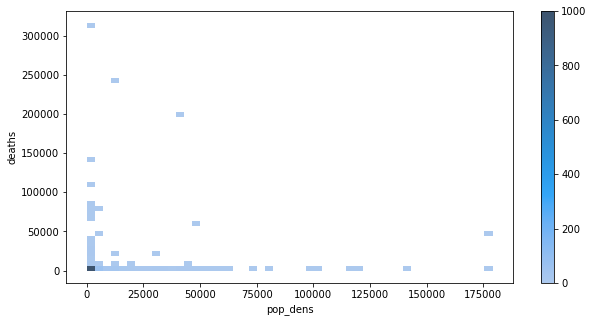

In [149]:
plt.figure(figsize=(10,5))
sns.histplot(data=eq, x='pop_dens', y='deaths', bins=50, cbar=True)

In [150]:
len(eq[eq['pop_dens']>1e5]) # 14 earthquakes near places with population density > 1e5

14

In [151]:
# Plot earthquake locations with colour = population density on a map (N.B. log colour scale). Plot hidden to reduce notebook file size (can't view on github anyway).
# fig = px.scatter_geo(eq, lat='latitude', lon='longitude', hover_name='locationName', color=np.log10(eq['pop_dens']),
#                     color_continuous_scale='Hot')
# fig.update_layout(title='Earthquakes nearby population density (people/100km^2)', title_x=0.5,
#                  coloraxis_colorbar=dict(
#                     title="pop_dens",
#                     tickvals=[-4,-2,0,2,4,6],
#                     ticktext=['0.0001', '0.01', '1', '100', '10,000', '1,000,000']
#                  )
#                  )
# fig.update_traces(marker=dict(size=2))
# fig.show()

In [152]:
# Do the same again but not in log scale, neglecting the earthquakes with very small/large population densities. Plot hidden to reduce notebook file size (can't view on github anyway).
# fig = px.scatter_geo(eq[(eq['pop_dens']<1000) & (eq['pop_dens']>0.01)], lat='latitude', lon='longitude', hover_name='locationName',
#                      color=eq[(eq['pop_dens']<1000) & (eq['pop_dens']>0.01)]['pop_dens'], color_continuous_scale='Hot')
# fig.update_layout(title='Earthquakes nearby population density (people/100km^2), neglecting small/large pop. dens.', title_x=0.5,
# #                  coloraxis_colorbar=dict(
# #                     title="pop_dens",
# #                     tickvals=[-1,0,1,2,3],
# #                     ticktext=['0.1', '1', '10', '100', '1,000']
# #                  )
#                  )
# fig.update_traces(marker=dict(size=2))
# fig.show()

In [153]:
# These plots are in approximate agreement with the population densities found online, for example:

![world_pop](World_population_density_1994_-_with_equator.png)

Source: https://upload.wikimedia.org/wikipedia/commons/4/49/World_population_density_1994_-_with_equator.png

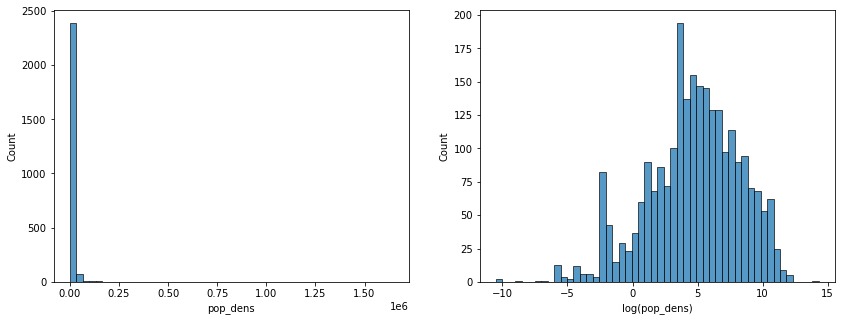

In [154]:
# Population density is right-skewed
# Simply taking the log of the distribution makes it more gaussian
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.histplot(x=eq['pop_dens'], bins=50, ax=ax[0])
sns.histplot(x=np.log(eq['pop_dens']), bins=50, ax=ax[1])
_ = ax[1].set_xlabel('log(pop_dens)')

In [155]:
import statsmodels.api as sm

C:\Users\emily\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.

C:\Users\emily\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



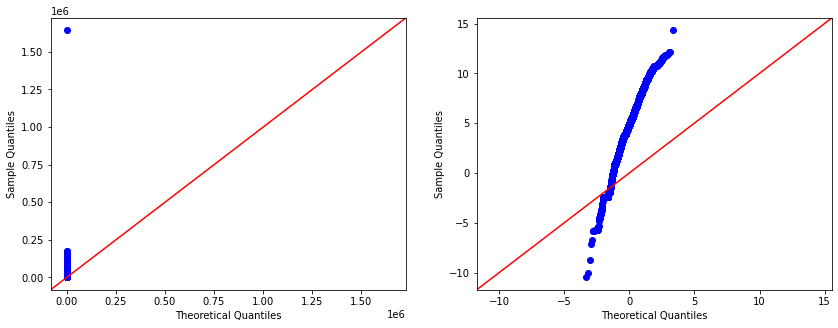

In [156]:
# Q-Q plots also show the improvement, although it isn't perfectly gaussian
fig, ax = plt.subplots(1,2, figsize=(14,5))
_ = sm.qqplot(eq['pop_dens'], line ='45', ax=ax[0])
_ = sm.qqplot(np.log(eq['pop_dens']), line ='45', ax=ax[1])

To do later (after train-test-split):
- Test whether another transformation (e.g. box-cox) can improve the gaussian-ness

In [157]:
# Create new log_pop_dens column and drop old one
eq['log_pop_dens'] = np.log(eq['pop_dens'])
eq.drop('pop_dens', axis=1, inplace=True)

In [158]:
eq.head()

,year,region,locationName,country,latitude,longitude,magnitude,depth,deaths,deathsCategory,damageMillionsDollarsCategory,caused_tsunami,caused_volcano,log_pop_dens
id,,,,,,,,,,,,,,
122,500,Central Asia and Caucasus,KAZAKHSTAN,KAZAKHSTAN,42.7,76.5,6.7,20.0,NaN,NaN,3.0,0,0,6.023938
276,942,Central Asia and Caucasus,UZBEKISTAN: BUKHARA,UZBEKISTAN,39.7,64.5,6.7,20.0,NaN,NaN,3.0,0,0,8.516710
464,1267,Middle East,IRAN: NEYSHABUR (NEISHABUR),IRAN,36.0,58.8,5.8,10.0,NaN,NaN,3.0,0,0,8.731032
472,1275,Central Asia and Caucasus,GEORGIA,GEORGIA,42.1,44.2,6.7,28.0,NaN,3.0,3.0,0,0,5.113992
481,1281,Middle East,IRAN: SHADIYAKH,IRAN,36.1,58.8,5.8,10.0,NaN,NaN,3.0,0,0,9.460052


<AxesSubplot:xlabel='damageMillionsDollarsCategory', ylabel='Count'>

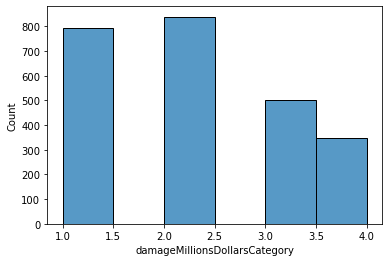

In [159]:
# Reasonable balance in the distribution of categorical values in damageMillionsDollarsCategory -> do nothing.
sns.histplot(x=eq['damageMillionsDollarsCategory'], bins=6)

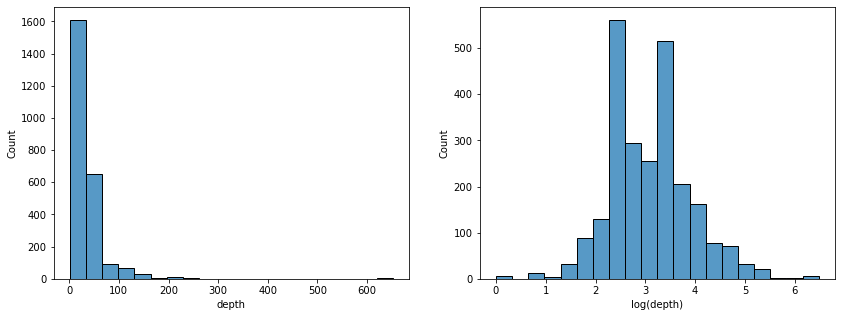

In [160]:
# Depth is right skewed, transform using log (adding 1 to each value to remove zeros)
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.histplot(x=eq['depth']+1, bins=20, ax=ax[0])
sns.histplot(x=np.log(eq['depth']+1), bins=20, ax=ax[1])
_ = ax[1].set_xlabel('log(depth)')

In [161]:
eq['log_depth'] = np.log(eq['depth']+1)

In [162]:
eq.drop('depth', axis=1, inplace=True)

<AxesSubplot:xlabel='magnitude', ylabel='Count'>

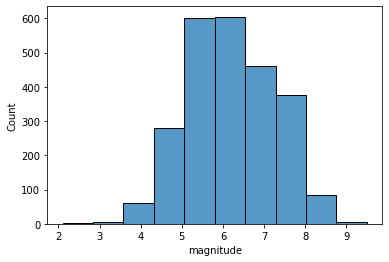

In [163]:
# Magnitude is technically already measured on a log scale so as expected, already looks gaussian
sns.histplot(x=eq['magnitude'], bins=10)

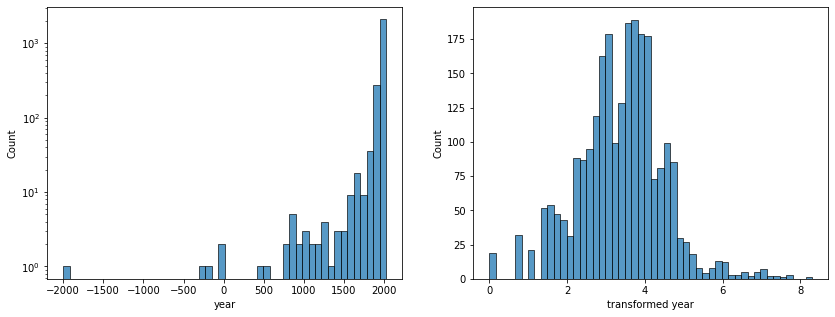

In [164]:
# The year could be interesting. Will try with/without it when training the ML models below.
# Year is left-skewed. Can transform it to be approx. gaussian by reflecting (using maximum year) followed by the log.
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.histplot(x=eq['year'], bins=50, log_scale=(False,True), ax=ax[0])
sns.histplot(x=np.log(max(eq['year'])-eq['year']+1), bins=50, ax=ax[1])
_ = ax[1].set_xlabel('transformed year')

In [165]:
eq['trans_year'] = np.log(max(eq['year'])-eq['year']+1)
eq.drop('year', axis=1, inplace=True)

In [166]:
# Finally, drop features that I don't want to/can't use
eq.drop(['region', 'locationName', 'country', 'latitude', 'longitude'], axis=1, inplace=True)

In [167]:
eq.head()

,magnitude,deaths,deathsCategory,damageMillionsDollarsCategory,caused_tsunami,caused_volcano,log_pop_dens,log_depth,trans_year
id,,,,,,,,,
122,6.7,NaN,NaN,3.0,0,0,6.023938,3.044522,7.328437
276,6.7,NaN,NaN,3.0,0,0,8.516710,3.044522,6.985642
464,5.8,NaN,NaN,3.0,0,0,8.731032,2.397895,6.628041
472,6.7,NaN,3.0,3.0,0,0,5.113992,3.367296,6.617403
481,5.8,NaN,NaN,3.0,0,0,9.460052,2.397895,6.609349


TODO:
- Investigate whether earthquakes occured in the same place. Seems to be repeated values in e.g. log(depth) distribution. Can't be duplicated values as I checked and removed those?

# Train-test split

I plan on trying to predict the number of deaths as well as classify the earthquakes according to the deathsCategory.

Before any ML, still have entries with NaN values in the deaths and deathsCategory. Will move these to another dataframe for later.

In [168]:
# Move entries with NaN values
eq_nan_deaths = eq[eq['deaths'].isna()]
eq_nan_deathsCategory = eq[eq['deathsCategory'].isna()]

In [169]:
eq_nan_deaths.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1225 entries, 122 to 10488
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   magnitude                      1225 non-null   float64
 1   deaths                         0 non-null      float64
 2   deathsCategory                 65 non-null     float64
 3   damageMillionsDollarsCategory  1225 non-null   float64
 4   caused_tsunami                 1225 non-null   int64  
 5   caused_volcano                 1225 non-null   int64  
 6   log_pop_dens                   1225 non-null   float64
 7   log_depth                      1225 non-null   float64
 8   trans_year                     1225 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 95.7 KB


In [170]:
eq_nan_deathsCategory.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1160 entries, 122 to 10488
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   magnitude                      1160 non-null   float64
 1   deaths                         0 non-null      float64
 2   deathsCategory                 0 non-null      float64
 3   damageMillionsDollarsCategory  1160 non-null   float64
 4   caused_tsunami                 1160 non-null   int64  
 5   caused_volcano                 1160 non-null   int64  
 6   log_pop_dens                   1160 non-null   float64
 7   log_depth                      1160 non-null   float64
 8   trans_year                     1160 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 90.6 KB


In [171]:
# Remove nan entries from eq
eq.dropna(axis=0, inplace=True)

In [172]:
eq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1256 entries, 1028 to 10640
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   magnitude                      1256 non-null   float64
 1   deaths                         1256 non-null   float64
 2   deathsCategory                 1256 non-null   float64
 3   damageMillionsDollarsCategory  1256 non-null   float64
 4   caused_tsunami                 1256 non-null   int64  
 5   caused_volcano                 1256 non-null   int64  
 6   log_pop_dens                   1256 non-null   float64
 7   log_depth                      1256 non-null   float64
 8   trans_year                     1256 non-null   float64
dtypes: float64(7), int64(2)
memory usage: 98.1 KB


Can now perform the train-test split.

In [173]:
from sklearn.model_selection import train_test_split

In [174]:
X = eq.drop(['deaths', 'deathsCategory'], axis=1)
y_reg = eq['deaths'] # regression
y_class = eq['deathsCategory'] # classification

In [175]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.3, random_state=111)

In [176]:
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.3, random_state=222)

# PCA

Aim: Understand which features are the most important.

In [178]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [179]:
sc = StandardScaler()

In [180]:
sc.fit(X_reg_train)

StandardScaler()

In [181]:
sc_X_reg_train = sc.fit_transform(X_reg_train) # fit and transform using training data
sc_X_reg_test = sc.transform(X_reg_test) # transform test data using scaling found from training data

In [182]:
pca = PCA(n_components=None, random_state=111)

In [183]:
pca.fit(sc_X_reg_train) # obtain components

PCA(random_state=111)

In [184]:
pca_components = pd.DataFrame(abs(pca.components_), index=range(1,8),
                              columns=eq.drop(['deaths','deathsCategory'], axis=1).columns)

In [185]:
pca_components

,magnitude,damageMillionsDollarsCategory,caused_tsunami,caused_volcano,log_pop_dens,log_depth,trans_year
1,0.600688,0.259302,0.506845,0.109403,0.232795,0.345802,0.359588
2,0.026507,0.765222,0.005604,0.195028,0.374126,0.459874,0.155599
3,0.004936,0.066630,0.257937,0.719036,0.255278,0.506715,0.300109
4,0.028675,0.115501,0.109269,0.589167,0.682807,0.225244,0.331391
5,0.271289,0.068781,0.383710,0.156352,0.493697,0.127622,0.699977
6,0.086564,0.500158,0.527771,0.246512,0.170841,0.466347,0.395440
7,0.746012,0.273001,0.488702,0.025504,0.038999,0.357317,0.016118


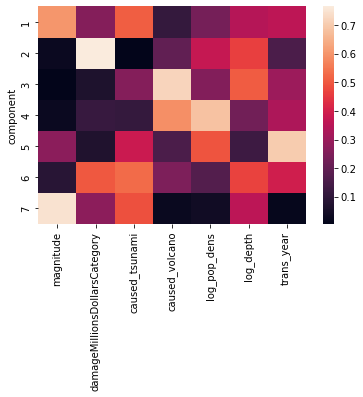

In [186]:
sns.heatmap(pca_components)
_ = plt.ylabel('component')

In [187]:
components = len(pca.explained_variance_ratio_)

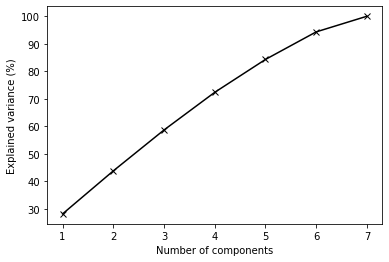

In [188]:
plt.plot(range(1,components+1), np.cumsum(pca.explained_variance_ratio_ * 100), 'kx-')
_ = plt.xlabel("Number of components")
_ = plt.ylabel("Explained variance (%)")

Although some features are slightly more important, all components are required to explain >95% of the variation. For example, magnitude contributes heavily to the first component but the first component only explains ~30% of the variation. Similarly, damage contributes heavily to the second component but the second component only explains ~15% of the variation from the first/second components combined.

# Regression

In [1]:
from sklearn import metrics

In [212]:
# Function that analyses prediction results for the models investigated later
def analyse_prediction_results(predictions, test):
    """
    Produce plots of prediction vs. true and true-prediction.
    
    Prints and returns mae and rmse for comparison of different models later on.
    """
    # Plot prediction vs. true
    plt.scatter(test, predictions, label='Prediction', s=2)
    plt.plot(range(0,350000), range(0,350000), 'r', label='y=x')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.xscale('log')
    plt.ylim([-13000,13000])
    plt.legend()
    
    # Plot test - predictions
    sns.displot((test-predictions), bins=50)
    plt.xlabel('true - predicted (g/km)')
    plt.yscale('log')
    
    # Metics
    mae = metrics.mean_absolute_error(test, predictions)
    rmse = np.sqrt(metrics.mean_squared_error(test, predictions))
    print('MAE:', mae)
    print('RMSE:', rmse)
    return mae, rmse

## Linear model

In [193]:
from sklearn.linear_model import LinearRegression

In [194]:
lm = LinearRegression()

In [195]:
lm.fit(X_reg_train, y_reg_train) # N.B. Scaled dataframe not needed

LinearRegression()

In [196]:
pd.DataFrame(lm.coef_, X_reg_train.columns, columns=['Coefficient'])

,Coefficient
magnitude,2094.615477
damageMillionsDollarsCategory,1837.137282
caused_tsunami,153.681400
caused_volcano,-3000.747850
log_pop_dens,414.089528
log_depth,-596.347310
trans_year,1144.857629


In [197]:
linear_predictions = lm.predict(X_reg_test)

MAE: 4342.423696907219
RMSE: 16831.48825225515


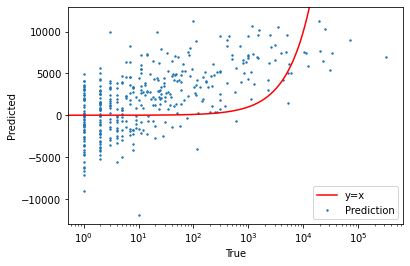

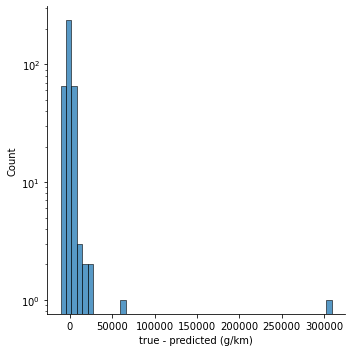

In [213]:
linear_mae, linear_rmse = analyse_prediction_results(linear_predictions, y_reg_test)

Linear model doesn't do a very good job! It is even predicting negative numbers of deaths.

There are, however, large outliers that will be affecting the result (or the interpretation of the result). Maybe if these were removed, this would improve. Before trying this, try a different model.

## Random forest

In [214]:
from sklearn.ensemble import RandomForestRegressor

In [215]:
rf = RandomForestRegressor()
rf.fit(X_reg_train, y_reg_train) # Again, scaled values are not needed

RandomForestRegressor()

In [216]:
rf_predictions = rf.predict(X_reg_test)

MAE: 2684.946889036251
RMSE: 17148.840938534187


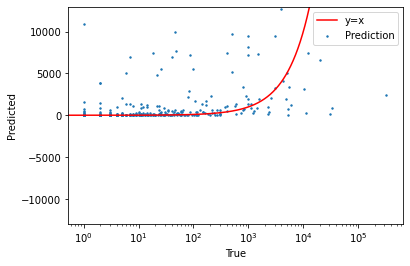

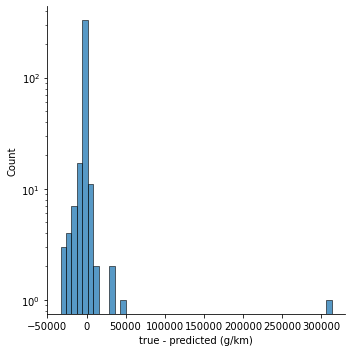

In [218]:
rf_mae, rf_rmse = analyse_prediction_results(rf_predictions, y_reg_test)

No longer getting negative numbers of deaths which is great. The MAE has also reduced by 38%, although the RMSE is about the same.

## KNN

In [224]:
from sklearn.neighbors import KNeighborsRegressor

In [226]:
knn = KNeighborsRegressor(n_neighbors=5)

In [227]:
knn.fit(sc_X_reg_train,y_reg_train) # N.B. Require scaled inputs here!

KNeighborsRegressor()

In [229]:
knn_predictions = knn.predict(sc_X_reg_test)

MAE: 2904.8594164456235
RMSE: 17870.642542775877


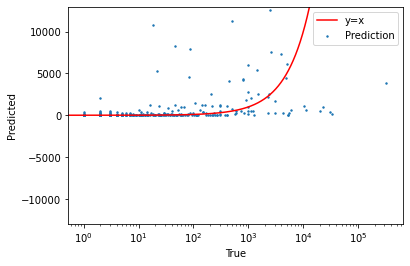

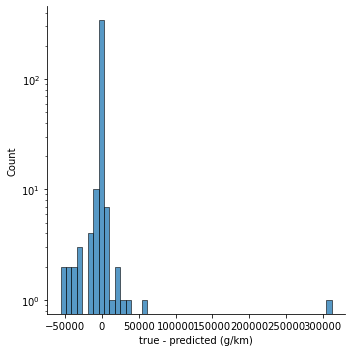

In [230]:
knn_mae, knn_rmse = analyse_prediction_results(knn_predictions, y_reg_test)

KNN produces very similar results (technically slightly worse) to the random forest.

## Hyperparameter optimisation

The models used above used the default parameters. Can these be optimised?

Whilst we're still keeping the outliers, will use the rmse to compare the models rather than the mae in order to penalise the larger errors.

In [205]:
import optuna

In [235]:
def objective(trial):
    """
    Function to optimise random forest hyperparameters by minimising the rmse.
    """
    # Specify parameters to optimise
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 10, 400)
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
    # Create regressor
    rf = RandomForestRegressor(max_depth=rf_max_depth, n_estimators=rf_n_estimators)
    # Do training
    rf.fit(X_reg_train, y_reg_train)
    # Predict
    rf_predictions = rf.predict(X_reg_test)
    # Return rmse
    rmse = np.sqrt(metrics.mean_squared_error(y_reg_test, rf_predictions))
    return rmse

In [237]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2022-07-08 10:36:54,833] A new study created in memory with name: no-name-d0f1f5ac-349e-432f-941d-f6414e6b151e
C:\Users\emily\anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-07-08 10:36:55,546] Trial 0 finished with value: 17150.1701446643 and parameters: {'rf_n_estimators': 143, 'rf_max_depth': 30}. Best is trial 0 with value: 17150.1701446643.
[I 2022-07-08 10:36:55,608] Trial 1 finished with value: 17569.571282672456 and parameters: {'rf_n_estimators': 11, 'rf_max_depth': 29}. Best is trial 0 with value: 17150.1701446643.
[I 2022-07-08 10:36:56,404] Trial 2 finished with value: 17264.55608756472 and parameters: {'rf_n_estimators': 193, 'rf_max_depth': 12}. Best is trial 0 with value: 17150.1701446643.
[I 2022-07-08 10:36:56,609] Trial 3 finished with value: 17267.347115849585 and parameters: {'rf_n_estimators': 47, 'rf_max_depth': 17}. Best is trial 0 with value: 17150.1701446643.
[I 2022-07-08 10:36:57,335] Trial 4 finished with value: 17253.067345559088 and parameters: {'rf_n_estimators': 119, 'rf_max_depth': 25}. Best is trial 0 with value: 17150.1701446643.
[I 2022-07-08 10:36:57,720] Trial 5 finished with value: 17468.845652053125 and param

[I 2022-07-08 10:37:15,151] Trial 42 finished with value: 17081.677198926747 and parameters: {'rf_n_estimators': 180, 'rf_max_depth': 3}. Best is trial 25 with value: 16854.266245971707.
[I 2022-07-08 10:37:15,516] Trial 43 finished with value: 16938.029017174882 and parameters: {'rf_n_estimators': 192, 'rf_max_depth': 2}. Best is trial 25 with value: 16854.266245971707.
[I 2022-07-08 10:37:15,893] Trial 44 finished with value: 17276.773730993656 and parameters: {'rf_n_estimators': 155, 'rf_max_depth': 4}. Best is trial 25 with value: 16854.266245971707.
[I 2022-07-08 10:37:16,044] Trial 45 finished with value: 17154.093054255678 and parameters: {'rf_n_estimators': 37, 'rf_max_depth': 5}. Best is trial 25 with value: 16854.266245971707.
[I 2022-07-08 10:37:16,445] Trial 46 finished with value: 17017.52945713905 and parameters: {'rf_n_estimators': 200, 'rf_max_depth': 3}. Best is trial 25 with value: 16854.266245971707.
[I 2022-07-08 10:37:16,965] Trial 47 finished with value: 17129.209

[I 2022-07-08 10:37:31,023] Trial 84 finished with value: 17238.251654059964 and parameters: {'rf_n_estimators': 108, 'rf_max_depth': 4}. Best is trial 25 with value: 16854.266245971707.
[I 2022-07-08 10:37:31,235] Trial 85 finished with value: 16918.80769111619 and parameters: {'rf_n_estimators': 92, 'rf_max_depth': 2}. Best is trial 25 with value: 16854.266245971707.
[I 2022-07-08 10:37:31,465] Trial 86 finished with value: 17063.33917822774 and parameters: {'rf_n_estimators': 104, 'rf_max_depth': 3}. Best is trial 25 with value: 16854.266245971707.
[I 2022-07-08 10:37:31,767] Trial 87 finished with value: 17255.380526940597 and parameters: {'rf_n_estimators': 115, 'rf_max_depth': 5}. Best is trial 25 with value: 16854.266245971707.
[I 2022-07-08 10:37:31,915] Trial 88 finished with value: 17163.16099475726 and parameters: {'rf_n_estimators': 53, 'rf_max_depth': 4}. Best is trial 25 with value: 16854.266245971707.
[I 2022-07-08 10:37:32,119] Trial 89 finished with value: 16874.847616

Small improvement for the random forest using the optimisation.

In [238]:
def objective(trial):
    """
    Function to optimise knn hyperparameters by minimising the rmse.
    """
    # Specify parameters to optimise
    knn_n_neighbors = trial.suggest_int('knn_n_neighbors', 1, 20)
    # Create regressor
    knn = KNeighborsRegressor(n_neighbors=knn_n_neighbors)
    # Do training
    knn.fit(sc_X_reg_train, y_reg_train) # scaled inputs
    # Predict
    knn_predictions = knn.predict(sc_X_reg_test)
    # Return rmse
    rmse = np.sqrt(metrics.mean_squared_error(y_reg_test, knn_predictions))
    return rmse

In [239]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2022-07-08 10:42:44,554] A new study created in memory with name: no-name-b1874c09-0908-4df4-8315-8db512c93c85
C:\Users\emily\anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-07-08 10:42:44,611] Trial 0 finished with value: 18338.60205770568 and parameters: {'knn_n_neighbors': 3}. Best is trial 0 with value: 18338.60205770568.
[I 2022-07-08 10:42:44,626] Trial 1 finished with value: 16839.05445023672 and parameters: {'knn_n_neighbors': 15}. Best is trial 1 with value: 16839.05445023672.
[I 2022-07-08 10:42:44,644] Trial 2 finished with value: 16726.35436674512 and parameters: {'knn_n_neighbors': 11}. Best is trial 2 with value: 16726.35436674512.
[I 2022-07-08 10:42:44,659] Trial 3 finished with value: 16839.05445023672 and parameters: {'knn_n_neighbors': 15}. Best is trial 2 with value: 16726.35436674512.
[I 2022-07-08 10:42:44,680] Trial 4 finished with value: 16792.6578690406 and parameters: {'knn_n_neighbors': 20}. Best is trial 2 with value: 16726.35436674512.
[I 2022-07-08 10:42:44,695] Trial 5 finished with value: 16783.15277739466 and parameters: {'knn_n_neighbors': 8}. Best is trial 2 with value: 16726.35436674512.
[I 2022-07-08 10:42:44,71

[I 2022-07-08 10:42:45,856] Trial 48 finished with value: 16812.572255273855 and parameters: {'knn_n_neighbors': 12}. Best is trial 2 with value: 16726.35436674512.
[I 2022-07-08 10:42:45,877] Trial 49 finished with value: 16839.05445023672 and parameters: {'knn_n_neighbors': 15}. Best is trial 2 with value: 16726.35436674512.
[I 2022-07-08 10:42:45,901] Trial 50 finished with value: 16783.15277739466 and parameters: {'knn_n_neighbors': 8}. Best is trial 2 with value: 16726.35436674512.
[I 2022-07-08 10:42:45,919] Trial 51 finished with value: 21787.93136898321 and parameters: {'knn_n_neighbors': 1}. Best is trial 2 with value: 16726.35436674512.
[I 2022-07-08 10:42:45,943] Trial 52 finished with value: 16726.35436674512 and parameters: {'knn_n_neighbors': 11}. Best is trial 2 with value: 16726.35436674512.
[I 2022-07-08 10:42:45,972] Trial 53 finished with value: 16726.35436674512 and parameters: {'knn_n_neighbors': 11}. Best is trial 2 with value: 16726.35436674512.
[I 2022-07-08 10:

[I 2022-07-08 10:42:47,179] Trial 96 finished with value: 16796.924007511963 and parameters: {'knn_n_neighbors': 19}. Best is trial 2 with value: 16726.35436674512.
[I 2022-07-08 10:42:47,209] Trial 97 finished with value: 16812.572255273855 and parameters: {'knn_n_neighbors': 12}. Best is trial 2 with value: 16726.35436674512.
[I 2022-07-08 10:42:47,230] Trial 98 finished with value: 16832.291851032776 and parameters: {'knn_n_neighbors': 13}. Best is trial 2 with value: 16726.35436674512.
[I 2022-07-08 10:42:47,253] Trial 99 finished with value: 16844.268998837382 and parameters: {'knn_n_neighbors': 14}. Best is trial 2 with value: 16726.35436674512.


Small improvement for the knn using the optimisation.

## Regression after removal of outliers

Dataset clearly contains some outliers. Remove these using the IQR in order to try and improve the model predictions.

Will only remove univariate (deaths) outliers for now.

In [247]:
# Find IQR
Q1 = eq['deaths'].quantile(0.25) # 1st quartile
Q3 = eq['deaths'].quantile(0.75) # 3rd quartile
IQR = Q3 - Q1
print(Q1, Q3, IQR)

2.0 76.75 74.75


In [248]:
eq.shape

(1254, 9)

In [251]:
# Remove earthquakes with deaths outside of range [Q1-1.5*IQR, Q3+1.5*IQR]
eq_no_out = eq[(eq['deaths']>(Q1-1.5*IQR)) & (eq['deaths']<(Q3+1.5*IQR))]

In [255]:
# New train-test split
X_no_out = eq_no_out.drop(['deaths', 'deathsCategory'], axis=1)
y_reg_no_out = eq_no_out['deaths'] # regression
X_reg_train_no_out, X_reg_test_no_out, y_reg_train_no_out, y_reg_test_no_out = train_test_split(X_no_out, y_reg_no_out, test_size=0.3, random_state=111)

In [256]:
# Random forest model
rf = RandomForestRegressor()
rf.fit(X_reg_train_no_out, y_reg_train_no_out) # Again, scaled values are not needed
rf_predictions = rf.predict(X_reg_test_no_out)

MAE: 21.29485776330076
RMSE: 32.67934045908997


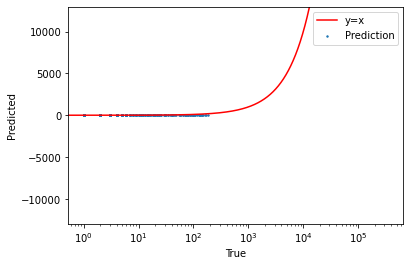

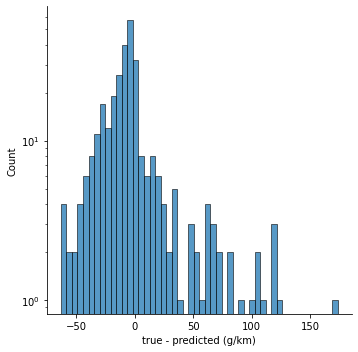

In [257]:
rf_mae_no_out, rf_rmse_no_out = analyse_prediction_results(rf_predictions, y_reg_test_no_out)

In [259]:
eq_no_out['deaths'].describe()

count    1023.000000
mean       19.799609
std        34.050784
min         1.000000
25%         2.000000
50%         5.000000
75%        20.000000
max       185.000000
Name: deaths, dtype: float64

As expected, mae and rmse reduced dramatically but on the scale of the deaths we're looking at (O(10)), the predictions are still very poor (relative error >100%).

## Training without 'year'

The 'year' feature may be adversely affecting the prediction as it may/may not be relevant and could result in overfitting. Try removing it and look for improvement.

In [260]:
# Remove year feature
eq_no_year = eq.drop('trans_year', axis=1)

In [261]:
# New train-test split
X_no_year = eq_no_year.drop(['deaths', 'deathsCategory'], axis=1)
y_reg_no_year = eq_no_year['deaths'] # regression
X_reg_train_no_year, X_reg_test_no_year, y_reg_train_no_year, y_reg_test_no_year = train_test_split(X_no_year, y_reg_no_year, test_size=0.3, random_state=111)

In [262]:
# Random forest model
rf = RandomForestRegressor()
rf.fit(X_reg_train_no_year, y_reg_train_no_year) # Again, scaled values are not needed
rf_predictions = rf.predict(X_reg_test_no_year)

MAE: 2753.050920424403
RMSE: 16296.953445766057


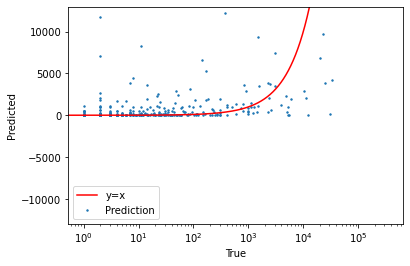

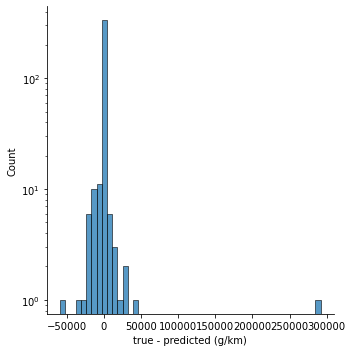

In [263]:
rf_mae_no_year, rf_rmse_no_year = analyse_prediction_results(rf_predictions, y_reg_test_no_year)

This is a bit better than before but unfortunately still poor.

## Possible improvements

Improvements that could be made to hopefully improve the prediction power:
- Use a better estimate of the local population density (e.g. sum of tiles surrounding earthquake location).
- Use GDP/capita of each country as a proxy for e.g. building quality/earthquake response/emergency service response.
- Try without removing time of day. More people are inside at certain times of day (e.g. overnight).
- Try removing "caused tsunami/volcano" feature. This may skew the results as they can be devastating and affect large areas.
- Optimise method used to remove missing data (e.g. remove features I now know I won't be using first). Can also attempt to use regression to predict some of the missing values.
- Try box-cox transformation of variables instead of simply using log.

# Classification

Can we do better by, instead of predicting the number of deaths, predicting the 'deathsCategory' each earthquake belongs in?

<AxesSubplot:xlabel='deathsCategory', ylabel='Count'>

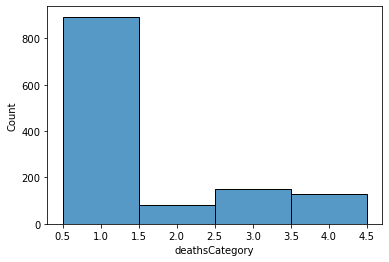

In [194]:
# The target classes we're predicting aren't reasonable balanced - may need to do something but let's try as is for now.
sns.histplot(x=eq['deathsCategory'], bins=4, binrange=(0.5,4.5))

## Logistic regression

- Going to use a grid search with cross validation to find the optimal C value.
- LogisticRegressionCV, by default, uses stratified k fold over standard k fold. This is kept as our dataset is imbalanced.
- In terms of the metric, going to use f1-score as the scorer as the dataset is imbalanced so accuracy/precision alone won't work.

In [182]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

In [187]:
# Need a custom scorer to allow f1-score to be used for multiclass classification.
custom_f1 = make_scorer(f1_score, average="weighted") # weighted average used as I have an imbalanced dataset

In [287]:
# Cs=10 means 10 values used in range [1e-4, 1e4]. Solver set to newton-cg as others didn't converge within 100 iterations.
logmodel = LogisticRegressionCV(solver='newton-cg', Cs=10, scoring=custom_f1, verbose=1, multi_class="multinomial")

In [288]:
logmodel.fit(X_class_train, y_class_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


LogisticRegressionCV(multi_class='multinomial',
                     scoring=make_scorer(f1_score, average=weighted),
                     solver='newton-cg', verbose=1)

In [289]:
logmodel.Cs_ # C values used in the grid search

array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])

In [290]:
logmodel.scores_ 
# keys=classes, values=array of scores for each C value from each fold in the cross validation. 
# Numbers repeated for each class as multinomial classification so essentially doing all classes at once.

{1.0: array([[0.58988976, 0.58988976, 0.61253225, 0.68394465, 0.68065747,
         0.68715535, 0.68640656, 0.68640656, 0.68640656, 0.68640656],
        [0.58988976, 0.58988976, 0.62504903, 0.68774178, 0.68304887,
         0.70334102, 0.70334102, 0.70334102, 0.70334102, 0.70334102],
        [0.5952381 , 0.5952381 , 0.58964525, 0.66475668, 0.69822281,
         0.70374512, 0.69961807, 0.70073881, 0.70073881, 0.70073881],
        [0.5952381 , 0.5952381 , 0.64068445, 0.67481617, 0.69265745,
         0.68915114, 0.68623377, 0.6832951 , 0.6832951 , 0.6832951 ],
        [0.58771142, 0.58771142, 0.5896836 , 0.67967112, 0.67697613,
         0.69291402, 0.69291402, 0.69291402, 0.69291402, 0.69291402]]),
 2.0: array([[0.58988976, 0.58988976, 0.61253225, 0.68394465, 0.68065747,
         0.68715535, 0.68640656, 0.68640656, 0.68640656, 0.68640656],
        [0.58988976, 0.58988976, 0.62504903, 0.68774178, 0.68304887,
         0.70334102, 0.70334102, 0.70334102, 0.70334102, 0.70334102],
        [0.5952

In [291]:
logmodel.C_[0] # Best C value in gridsearch. Only need first element as all the same as multinomial classification.

2.782559402207126

In [292]:
logpred = logmodel.predict(X_class_test)

In [293]:
# Comments on this made below
print(classification_report(y_class_test,logpred))

              precision    recall  f1-score   support

         1.0       0.81      0.96      0.88       270
         2.0       0.00      0.00      0.00        26
         3.0       0.33      0.05      0.08        44
         4.0       0.53      0.76      0.62        37

    accuracy                           0.77       377
   macro avg       0.42      0.44      0.40       377
weighted avg       0.67      0.77      0.70       377



C:\Users\emily\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\emily\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\emily\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [294]:
# Can we do better using class_weight="balanced"? This adjusts the weights based on class frequencies.
logmodel_bal = LogisticRegressionCV(solver='newton-cg', Cs=10, scoring=custom_f1, verbose=1, multi_class="multinomial", class_weight="balanced")

In [295]:
logmodel_bal.fit(X_class_train, y_class_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.0s finished


LogisticRegressionCV(class_weight='balanced', multi_class='multinomial',
                     scoring=make_scorer(f1_score, average=weighted),
                     solver='newton-cg', verbose=1)

In [296]:
logmodel_bal.scores_

{1.0: array([[0.49738863, 0.60411837, 0.64055158, 0.6546247 , 0.65153848,
         0.64973128, 0.65427355, 0.65427355, 0.65427355, 0.65427355],
        [0.60497528, 0.6402194 , 0.7019082 , 0.68121921, 0.68947892,
         0.68497816, 0.68497816, 0.68497816, 0.68497816, 0.68497816],
        [0.57480424, 0.64991878, 0.66719618, 0.65214715, 0.65923708,
         0.65692541, 0.66407967, 0.66407967, 0.66407967, 0.66407967],
        [0.63637562, 0.65829931, 0.68612531, 0.68042589, 0.67561327,
         0.66896147, 0.65633596, 0.65633596, 0.65633596, 0.65633596],
        [0.58861578, 0.6342452 , 0.64452338, 0.65498907, 0.66033062,
         0.63969403, 0.64051669, 0.64051669, 0.64051669, 0.64051669]]),
 2.0: array([[0.49738863, 0.60411837, 0.64055158, 0.6546247 , 0.65153848,
         0.64973128, 0.65427355, 0.65427355, 0.65427355, 0.65427355],
        [0.60497528, 0.6402194 , 0.7019082 , 0.68121921, 0.68947892,
         0.68497816, 0.68497816, 0.68497816, 0.68497816, 0.68497816],
        [0.5748

In [297]:
logmodel_bal.C_[0] # Best C is different now but f1-scores fairly similar across all C values

0.005994842503189409

In [300]:
logpred_bal = logmodel_bal.predict(X_class_test)

In [302]:
# Compare the two models
print("Without frequency adjusted weights:")
print(classification_report(y_class_test,logpred, zero_division=0))
print("\nWith frequency adjusted weights:")
print(classification_report(y_class_test,logpred_bal, zero_division=0))

Without frequency adjusted weights:
              precision    recall  f1-score   support

         1.0       0.81      0.96      0.88       270
         2.0       0.00      0.00      0.00        26
         3.0       0.33      0.05      0.08        44
         4.0       0.53      0.76      0.62        37

    accuracy                           0.77       377
   macro avg       0.42      0.44      0.40       377
weighted avg       0.67      0.77      0.70       377


With frequency adjusted weights:
              precision    recall  f1-score   support

         1.0       0.92      0.79      0.85       270
         2.0       0.12      0.12      0.12        26
         3.0       0.22      0.25      0.24        44
         4.0       0.38      0.76      0.51        37

    accuracy                           0.67       377
   macro avg       0.41      0.48      0.43       377
weighted avg       0.73      0.67      0.69       377



Summary:
- In both cases, predicting class 1 well. This is expected as it is the majority class. The prediction worsens slightly when we adjust the weights for the class frequency but we do benefit in other classes, as mentioned below.
- Without adjusting weights for class frequencies, classes 2 and 3 are very poorly predicted (0 and 0.08 f1-scores). This is improved by adjusting weights for class frequency but predictions are still not great (0.12 and 0.24 f1-scores). 
- In class 4, the prediction is ok but not great. Interestingly, the f1-score worsens slightly when the weights are adjusted despite the low frequency in this class. This is due to the decrease in precision. I guess this is the cost of the improvements made in classes 2 and 3?
- The macro/weighted average f1-score is very similar without/with adjusting the weights. I guess the overall situation could be improved by changing this to a binary classification problem (combine classes 2, 3 and 4).

## Random forest

Can a random forest classifier do any better than the logistic regression?

Will try using default parameters first, then do a grid search/hyperparameter optimisation.

In [177]:
from sklearn.ensemble import RandomForestClassifier

In [178]:
# class_weight="balanced" means weights are computed based on the class frequencies
rfc = RandomForestClassifier(class_weight='balanced')

In [179]:
rfc.fit(X_class_train, y_class_train)

RandomForestClassifier(class_weight='balanced')

In [180]:
rfc_pred = rfc.predict(X_class_test)

In [183]:
print(classification_report(y_class_test, rfc_pred))

              precision    recall  f1-score   support

         1.0       0.77      0.97      0.86       256
         2.0       0.00      0.00      0.00        29
         3.0       0.38      0.11      0.17        54
         4.0       0.56      0.53      0.54        38

    accuracy                           0.73       377
   macro avg       0.43      0.40      0.39       377
weighted avg       0.63      0.73      0.66       377



This is very similar (but actually a bit worse) than the logistic regression so far but can the RF hyperparameters be optimised?

In [184]:
# No random forest equivalent of LogisticRegressionCV so need GridSearch instead
from sklearn.model_selection import GridSearchCV

In [185]:
param_grid = {'n_estimators': list(range(20,320,20)),
              'max_depth': list(range(2,34,2))}

In [188]:
grid_rfc = GridSearchCV(rfc, param_grid, cv=10, scoring=custom_f1) # use custom f1-score from earlier

In [189]:
grid_rfc.fit(X_class_train, y_class_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22,
                                       24, 26, 28, 30, 32],
                         'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160,
                                          180, 200, 220, 240, 260, 280, 300]},
             scoring=make_scorer(f1_score, average=weighted))

In [191]:
grid_rfc.best_params_

{'max_depth': 8, 'n_estimators': 40}

In [192]:
grid_rfc.best_score_

0.7252944350024086

In [193]:
#grid_rfc.cv_results_ # dict of various grid search results

In [332]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    """
    Plots grid search test score results for a 2 parameter search.
    """
    # Get test scores mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot grid search scores
    fig, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid search scores", fontsize=20)
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV average score', fontsize=16)
    ax.legend(fontsize=15, bbox_to_anchor=(1.1, 1.05))
    ax.grid('on')

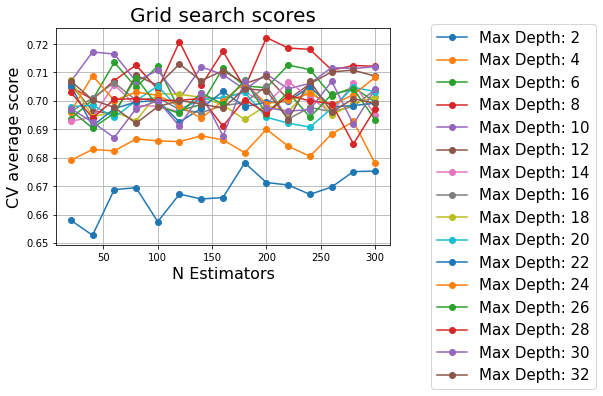

In [333]:
plot_grid_search(grid_rfc.cv_results_, param_grid['n_estimators'], param_grid['max_depth'], 'N Estimators', 'Max Depth')

- Small number of estimators is enough, test scores don't vary too much, especially at larger max depths.
- Max depths of 2 and 4 are noticably worse than larger values.

In [210]:
def analyse_best_model(max_depth, n_estimators):
    """
    Uses best parameters to create a new classifier and prints the classification report.
    """
    # Create classifier
    rfc = RandomForestClassifier(class_weight='balanced', max_depth=max_depth, n_estimators=n_estimators)
    # Do training
    rfc.fit(X_class_train, y_class_train)
    # Predict
    rfc_pred = rfc.predict(X_class_test)

    print(classification_report(y_class_test, rfc_pred))

In [355]:
# Grid search best results
analyse_best_model(grid_rfc.best_params_['max_depth'], grid_rfc.best_params_['n_estimators'])

              precision    recall  f1-score   support

         1.0       0.87      0.89      0.88       270
         2.0       0.08      0.04      0.05        26
         3.0       0.31      0.27      0.29        44
         4.0       0.44      0.59      0.51        37

    accuracy                           0.73       377
   macro avg       0.42      0.45      0.43       377
weighted avg       0.71      0.73      0.71       377



Does the hyperparameter optimisation package optuna produce a better result than the grid search?

In [334]:
def objective(trial):
    """
    Function to optimise random forest hyperparameters by maximising the f1-score.
    """
    # Specify parameters to optimise
    rfc_n_estimators = trial.suggest_int('rfc_n_estimators', 20, 300)
    rfc_max_depth = trial.suggest_int('rfc_max_depth', 2, 32)
    # Create classifier
    rfc = RandomForestClassifier(class_weight='balanced', max_depth=rfc_max_depth, n_estimators=rfc_n_estimators)
    # Do training
    rfc.fit(X_class_train, y_class_train)
    # Predict
    rfc_pred = rfc.predict(X_class_test)
    # Return f1-score
    f1 = f1_score(y_class_test, rfc_pred, average='weighted') # 'weighted' means class support/frequency is accounted for
    return f1

In [335]:
# Run optimisation
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2022-07-15 14:31:42,126] A new study created in memory with name: no-name-4982d07a-bb6f-4cca-90b0-acb0d53e664d
C:\Users\emily\anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-07-15 14:31:42,929] Trial 0 finished with value: 0.7004035823991461 and parameters: {'rfc_n_estimators': 235, 'rfc_max_depth': 23}. Best is trial 0 with value: 0.7004035823991461.
[I 2022-07-15 14:31:44,380] Trial 1 finished with value: 0.6983854931704431 and parameters: {'rfc_n_estimators': 279, 'rfc_max_depth': 31}. Best is trial 0 with value: 0.7004035823991461.
[I 2022-07-15 14:31:45,136] Trial 2 finished with value: 0.7064348503091589 and parameters: {'rfc_n_estimators': 257, 'rfc_max_depth': 14}. Best is trial 2 with value: 0.7064348503091589.
[I 2022-07-15 14:31:45,402] Trial 3 finished with value: 0.6930210853627053 and parameters: {'rfc_n_estimators': 98, 'rfc_max_depth': 6}. Best is trial 2 with value: 0.7064348503091589.
[I 2022-07-15 14:31:45,740] Trial 4 finished with value: 0.7156301142042241 and parameters: {'rfc_n_estimators': 126, 'rfc_max_depth': 31}. Best is trial 4 with value: 0.7156301142042241.
[I 2022-07-15 14:31:45,822] Trial 5 finished with value: 0.687

[I 2022-07-15 14:32:05,929] Trial 41 finished with value: 0.7118791398413423 and parameters: {'rfc_n_estimators': 217, 'rfc_max_depth': 9}. Best is trial 38 with value: 0.731187257911396.
[I 2022-07-15 14:32:06,631] Trial 42 finished with value: 0.7170723426307147 and parameters: {'rfc_n_estimators': 276, 'rfc_max_depth': 10}. Best is trial 38 with value: 0.731187257911396.
[I 2022-07-15 14:32:07,253] Trial 43 finished with value: 0.710934549951583 and parameters: {'rfc_n_estimators': 235, 'rfc_max_depth': 11}. Best is trial 38 with value: 0.731187257911396.
[I 2022-07-15 14:32:07,957] Trial 44 finished with value: 0.7198207964802058 and parameters: {'rfc_n_estimators': 251, 'rfc_max_depth': 13}. Best is trial 38 with value: 0.731187257911396.
[I 2022-07-15 14:32:08,444] Trial 45 finished with value: 0.6785913086425451 and parameters: {'rfc_n_estimators': 221, 'rfc_max_depth': 4}. Best is trial 38 with value: 0.731187257911396.
[I 2022-07-15 14:32:08,819] Trial 46 finished with value: 

[I 2022-07-15 14:32:30,015] Trial 82 finished with value: 0.7161801902625039 and parameters: {'rfc_n_estimators': 260, 'rfc_max_depth': 9}. Best is trial 38 with value: 0.731187257911396.
[I 2022-07-15 14:32:30,781] Trial 83 finished with value: 0.7108755388663877 and parameters: {'rfc_n_estimators': 287, 'rfc_max_depth': 11}. Best is trial 38 with value: 0.731187257911396.
[I 2022-07-15 14:32:31,445] Trial 84 finished with value: 0.703963887393082 and parameters: {'rfc_n_estimators': 271, 'rfc_max_depth': 7}. Best is trial 38 with value: 0.731187257911396.
[I 2022-07-15 14:32:32,176] Trial 85 finished with value: 0.7327753573949894 and parameters: {'rfc_n_estimators': 278, 'rfc_max_depth': 10}. Best is trial 85 with value: 0.7327753573949894.
[I 2022-07-15 14:32:32,376] Trial 86 finished with value: 0.7177580805121048 and parameters: {'rfc_n_estimators': 72, 'rfc_max_depth': 10}. Best is trial 85 with value: 0.7327753573949894.
[I 2022-07-15 14:32:32,995] Trial 87 finished with value:

In [340]:
print('best params = ', study.best_trial.params)
print('f1-score = ', study.best_trial.value)

best params =  {'rfc_n_estimators': 278, 'rfc_max_depth': 10}
f1-score =  0.7327753573949894


In [363]:
analyse_best_model(study.best_trial.params['rfc_max_depth'], study.best_trial.params['rfc_n_estimators'])

              precision    recall  f1-score   support

         1.0       0.84      0.93      0.88       270
         2.0       0.20      0.04      0.06        26
         3.0       0.38      0.25      0.30        44
         4.0       0.48      0.54      0.51        37

    accuracy                           0.75       377
   macro avg       0.47      0.44      0.44       377
weighted avg       0.70      0.75      0.72       377



- Optuna produces ever so slightly better results than the grid search and was also much much faster to run. This better results may just be statistical variation however.
- Best parameters it found are similar.

## SMOTE

Can the data imbalance be addressed by artificially creating more data based on the data available? On one hand, this may improve the classification. However, the data, by nature, is imbalanced as most earthquakes do not result in a large number of deaths.

That aside, will try using SMOTE to create more data.

In [193]:
from imblearn.over_sampling import SMOTE

In [197]:
y_class.value_counts()

1.0    894
3.0    152
4.0    128
2.0     80
Name: deathsCategory, dtype: int64

In [200]:
# Double the number of minority classes, leaving majority class the same
oversample = SMOTE(sampling_strategy={1 : 894, 2 : 160, 3 : 304, 4 : 256})

In [201]:
X_sm, y_class_sm = oversample.fit_resample(X, y_class)

In [228]:
y_class_sm.value_counts()

1.0    894
3.0    304
4.0    256
2.0    160
Name: deathsCategory, dtype: int64

In [202]:
X_class_train_sm, X_class_test_sm, y_class_train_sm, y_class_test_sm = train_test_split(X_sm, y_class_sm, test_size=0.3, random_state=222)

Use optuna to optimise the RF hyperparameters.

In [203]:
def objective(trial):
    """
    Function to optimise random forest hyperparameters by maximising the f1-score.
    The oversampled data is used.
    """
    # Specify parameters to optimise
    rfc_n_estimators = trial.suggest_int('rfc_n_estimators', 20, 300)
    rfc_max_depth = trial.suggest_int('rfc_max_depth', 2, 32)
    # Create classifier
    rfc = RandomForestClassifier(class_weight='balanced', max_depth=rfc_max_depth, n_estimators=rfc_n_estimators)
    # Do training
    rfc.fit(X_class_train_sm, y_class_train_sm)
    # Predict
    rfc_pred = rfc.predict(X_class_test_sm)
    # Return f1-score
    f1 = f1_score(y_class_test_sm, rfc_pred, average='weighted') # 'weighted' means class support/frequency is accounted for
    return f1

In [208]:
# Run the optimisation
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2022-07-15 15:43:52,198] A new study created in memory with name: no-name-9f8fcdf5-0b96-4d1b-b2a0-3e67af3bc443
C:\Users\emily\anaconda3\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]

[I 2022-07-15 15:43:54,006] Trial 0 finished with value: 0.7524612844890419 and parameters: {'rfc_n_estimators': 269, 'rfc_max_depth': 27}. Best is trial 0 with value: 0.7524612844890419.
[I 2022-07-15 15:43:54,901] Trial 1 finished with value: 0.7456947427883364 and parameters: {'rfc_n_estimators': 180, 'rfc_max_depth': 11}. Best is trial 0 with value: 0.7524612844890419.
[I 2022-07-15 15:43:56,006] Trial 2 finished with value: 0.7450353662239654 and parameters: {'rfc_n_estimators': 185, 'rfc_max_depth': 30}. Best is trial 0 with value: 0.7524612844890419.
[I 2022-07-15 15:43:57,325] Trial 3 finished with value: 0.7460933347303547 and parameters: {'rfc_n_estimators': 214, 'rfc_max_depth': 21}. Best is trial 0 with value: 0.7524612844890419.
[I 2022-07-15 15:43:59,219] Trial 4 finished with value: 0.7352124063265335 and parameters: {'rfc_n_estimators': 272, 'rfc_max_depth': 18}. Best is trial 0 with value: 0.7524612844890419.
[I 2022-07-15 15:44:00,065] Trial 5 finished with value: 0.6

[I 2022-07-15 15:44:25,081] Trial 41 finished with value: 0.7512172772883973 and parameters: {'rfc_n_estimators': 88, 'rfc_max_depth': 32}. Best is trial 17 with value: 0.7592284562455948.
[I 2022-07-15 15:44:25,803] Trial 42 finished with value: 0.7502329217401542 and parameters: {'rfc_n_estimators': 110, 'rfc_max_depth': 30}. Best is trial 17 with value: 0.7592284562455948.
[I 2022-07-15 15:44:26,346] Trial 43 finished with value: 0.754242657615506 and parameters: {'rfc_n_estimators': 90, 'rfc_max_depth': 31}. Best is trial 17 with value: 0.7592284562455948.
[I 2022-07-15 15:44:26,756] Trial 44 finished with value: 0.7521646731361077 and parameters: {'rfc_n_estimators': 69, 'rfc_max_depth': 28}. Best is trial 17 with value: 0.7592284562455948.
[I 2022-07-15 15:44:27,250] Trial 45 finished with value: 0.7179788128484937 and parameters: {'rfc_n_estimators': 94, 'rfc_max_depth': 8}. Best is trial 17 with value: 0.7592284562455948.
[I 2022-07-15 15:44:27,455] Trial 46 finished with value

[I 2022-07-15 15:44:50,189] Trial 82 finished with value: 0.7483100505205259 and parameters: {'rfc_n_estimators': 200, 'rfc_max_depth': 27}. Best is trial 57 with value: 0.7605438988330027.
[I 2022-07-15 15:44:51,191] Trial 83 finished with value: 0.7396369686910219 and parameters: {'rfc_n_estimators': 158, 'rfc_max_depth': 30}. Best is trial 57 with value: 0.7605438988330027.
[I 2022-07-15 15:44:52,140] Trial 84 finished with value: 0.7574603965516428 and parameters: {'rfc_n_estimators': 137, 'rfc_max_depth': 29}. Best is trial 57 with value: 0.7605438988330027.
[I 2022-07-15 15:44:53,258] Trial 85 finished with value: 0.7546729511403507 and parameters: {'rfc_n_estimators': 175, 'rfc_max_depth': 23}. Best is trial 57 with value: 0.7605438988330027.
[I 2022-07-15 15:44:54,551] Trial 86 finished with value: 0.7450982862956934 and parameters: {'rfc_n_estimators': 201, 'rfc_max_depth': 27}. Best is trial 57 with value: 0.7605438988330027.
[I 2022-07-15 15:44:55,844] Trial 87 finished with

In [233]:
analyse_best_model(study.best_trial.params['rfc_max_depth'], study.best_trial.params['rfc_n_estimators'])

              precision    recall  f1-score   support

         1.0       0.81      0.95      0.87       270
         2.0       0.00      0.00      0.00        26
         3.0       0.44      0.18      0.26        44
         4.0       0.47      0.49      0.48        37

    accuracy                           0.75       377
   macro avg       0.43      0.41      0.40       377
weighted avg       0.68      0.75      0.70       377



- Result is slightly worse than before. This may be a result of statistical variation but should be tested.

## Possible improvements

- Try using a different metric (i.e. not f1-score).
- Try using a different logistic regression solver (all but newton-cg wouldn't converge) with more iterations.
- Try merging classes 2, 3 and 4 into one class. This will improve the imbalance and should produce better results.
- Test whether the comparisons between models depend on statistical variation. Expected SMOTE to improve the results so if that is a result of statistical variation, maybe the previous comparisons/improvements made were also affected by this.
- Try additional models e.g. SVM, k means...
- Also see possible improvements subsection at the end of the "Regression" section.

# Concluding remarks

- Very interesting project overall and I learnt a lot whilst working on the feature engineering/ML.
- Didn't manage to predict the number of deaths very well but did a bit better when classifying them. There are a number of improvements that could be made to the methods performed (see earlier points at the end of each section) but more data would be especially useful (or even the same data with fewer missing features!).